<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_06__Haunted_DAG__and_The_Causal_Terror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
  !pip install networkx
  !pip install arviz
  !pip install causalgraphicalmodels
  !pip install daft
except:
  pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.8 MB/s eta 0:00:00


In [2]:
#@title import library
import numpy as np
import scipy.stats as stats
import pandas as pd
import daft
import networkx as nx
import statsmodels.formula.api as smf
import jax
import io
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
from collections import OrderedDict
tfd = tfp_jax.distributions
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import jaxopt
from jaxopt import ScipyMinimize
import arviz
import itertools
import collections
import arviz as az
key = jax.random.PRNGKey(42)

def marginal_test_results(model, results, nll,credib_interval = 0.89, num_of_samples = 10000):
  '''
  model: tfp model like
  results: results from optimizing
  nll: negative log likelihood function
  credib_interval: the interval we are interested in
  num_of_samples: number of samples we want to get from the posterior distribution
  '''
  key = jax.random.PRNGKey(42)
  inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
  mean_list = results.params
  sd_list = jnp.diagonal(inv_hessian_matrix)**(1/2)
  low_credib_interval = (1 - credib_interval)/2
  high_credib_interval = 1 - low_credib_interval
  parameter_list = []
  normal_dist = tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list)
  for _parameter in model.parameters['model']:
    if isinstance(model.parameters['model'][_parameter],tfp_jax.distributions.Distribution):
      try:
        _shape = model.parameters['model'][_parameter].event_shape[0]
        parameter_list.extend([_parameter + '_' +str(i) for i in range(0, _shape)])
      except:
        parameter_list.append(_parameter)

  df_result = pd.DataFrame({'mean': mean_list,
                           'sd':sd_list,
                            'low': normal_dist.quantile(low_credib_interval),
                            'high':tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list).quantile(high_credib_interval) },
                           index = parameter_list)
  post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
  post_samples = post_dist.sample( sample_shape=num_of_samples,seed=key)
  df_post_samples = pd.DataFrame(post_samples,columns = parameter_list)
  return df_result,inv_hessian_matrix,df_post_samples
credib_interval = 0.89

In [3]:
#@title 6.1
np.random.seed(1914)  # Set seed for reproducibility
N = 200             # Number of grant proposals
p = 0.1              # Proportion to select

# Generate uncorrelated newsworthiness and trustworthiness scores
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)

# Calculate total score
s = nw + tw

# Determine the threshold for the top 10%
q = np.quantile(s, 1 - p)

# Select proposals above the threshold
selected = s >= q

# Calculate the correlation between trustworthiness and newsworthiness for selected proposals
correlation = np.corrcoef(tw[selected], nw[selected])[0,1]

print(correlation)


-0.6483929491294511


In [4]:
#@title 6.2
N = 100
height = np.random.normal(10,2,N)
leg_prop = np.random.uniform(0.4,0.5,N)
leg_left = leg_prop*height + np.random.normal(0,0.02,N)
leg_right = leg_prop*height + np.random.normal(0,0.02,N)
d = pd.DataFrame({'height':height,'leg_left':leg_left,'leg_right':leg_right})

In [5]:
#@title reading the data from book to simulate same results
d = pd.read_csv(io.StringIO('''
height,leg_left,leg_right
5.931416955,2.679411473,2.70928614
6.51298334,2.676427688,2.680006751
9.346627917,3.927154928,3.984946748
9.233033497,3.964191068,3.993388926
10.35712817,4.427593165,4.418765765
10.0889226,4.95664064,4.971877867
13.05303445,5.404191204,5.399219538
7.498360791,3.539438477,3.579225558
13.81087151,6.300341319,6.29822427
7.329084991,3.230945506,3.274145028
12.61932224,5.127566756,5.132084685
12.68391751,5.359608747,5.366324791
12.06613652,5.741060474,5.748175022
10.05801071,4.329188499,4.323138132
12.42722547,5.911001365,5.921830976
16.44880782,7.153321385,7.14551902
9.937349262,4.681807289,4.698755785
10.57496264,4.233973369,4.263162337
12.32543692,5.56312629,5.530779548
9.555444182,4.407019201,4.387076685
11.33216842,4.61139999,4.638060772
10.61995019,4.462987178,4.458933212
12.01106303,5.784778123,5.797436884
14.90090496,6.79271827,6.769172138
11.42808673,5.499870386,5.509709203
7.031058933,3.351868887,3.298516253
6.671679811,2.726206139,2.730960637
9.628514693,4.613382762,4.612500945
9.265901788,4.238859594,4.255222597
12.39715654,6.055246736,6.029016983
12.32260175,6.123998655,6.164206071
11.87632601,4.738791198,4.71019902
11.04261338,5.20969175,5.152977327
9.210152738,3.779994948,3.744403974
9.762566258,4.509882077,4.50721495
9.696829468,4.770419952,4.754229411
9.587857216,4.398377382,4.38829894
8.571497774,3.473194728,3.461114377
7.649834704,3.405669662,3.383477736
7.98868596,3.471506612,3.476156583
8.86399818,4.328689813,4.33207554
9.113498171,4.170678665,4.195822472
10.35862915,4.568490271,4.534296431
9.679261033,4.687564236,4.687122834
11.25014263,5.429219947,5.423695895
8.359474024,3.890150025,3.89460142
5.262048509,2.386818473,2.388972492
12.26802891,5.893525686,5.881967737
11.00900513,4.74893325,4.763609624
10.8072811,5.257132808,5.253323382
8.696513786,3.650035934,3.653937434
9.761014923,3.902102397,3.907399086
11.81638279,5.645260549,5.654353229
9.301588895,4.029298823,4.011371305
11.44441623,4.812517398,4.817390133
10.22876589,5.058965057,5.058070752
8.272049951,3.331294988,3.368051306
6.97898325,3.370056035,3.403965789
9.621701044,4.507635153,4.496517462
9.330807696,3.756904617,3.760564272
8.218764444,3.676938823,3.679898217
10.25447353,4.232952887,4.218270793
9.038639768,4.021331676,4.019803357
9.709572302,4.566335292,4.541757045
9.294864971,4.364862232,4.406905974
15.9633626,7.614862567,7.635012419
11.35074107,5.11651666,5.146136035
4.57493818,2.138929581,2.111308965
10.86622271,4.715935185,4.716034739
12.91511429,5.5384129,5.53313914
11.79853891,5.744965458,5.73853486
11.43930487,5.542637714,5.552836432
7.163051639,3.286217178,3.281855638
7.834305792,3.368747225,3.435448551
9.899587707,4.854784063,4.841924422
8.593783276,4.092027513,4.050168775
11.47050283,5.007675684,4.973286775
7.928694369,3.653731252,3.64113848
8.861765102,4.331312896,4.328131016
13.06150026,6.178552019,6.185445128
10.10898232,4.399288277,4.396729193
8.875610083,4.136185948,4.1436414
9.126544644,3.711032914,3.681410829
8.947473007,4.013302506,4.016245634
8.940897114,4.003867648,4.008472835
9.40444061,4.59669973,4.578378832
11.13370494,5.450681256,5.440490509
8.907264204,4.379276919,4.340107293
9.354004083,4.682148223,4.664959867
12.30994415,5.05015261,5.063904296
8.865257263,4.281116332,4.294385232
12.12543816,5.154836901,5.170920697
7.934998285,3.549989679,3.567998679
12.22482668,5.240380141,5.262400719
8.649402665,3.730091655,3.767939396
8.404878832,3.768040132,3.792619036
11.65886607,5.439036239,5.400221176
11.86387841,5.635256869,5.641282298
7.504671204,3.036804466,3.019554916
7.617914862,3.271645414,3.246423266
'''), header=0)
display(d.head())

,height,leg_left,leg_right
0,5.931417,2.679411,2.709286
1,6.512983,2.676428,2.680007
2,9.346628,3.927155,3.984947
3,9.233033,3.964191,3.993389
4,10.357128,4.427593,4.418766


In [6]:
#@title 6.3
leg_left_arr = jnp.array(d['leg_left'])
leg_right_arr = jnp.array(d['leg_right'])
height_arr = jnp.array(d['height'])
model6_1 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=10.0,scale=100),
    bl = tfd.Normal(loc=2,scale=10),
    br = tfd.Normal(loc=2,scale=10),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda alpha,bl,br: tfd.Deterministic(alpha + bl * leg_left_arr + br * leg_right_arr),
    h = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_1(parameters):
  samples = model6_1.sample(
      h = height_arr,
      alpha = parameters[0],
      bl = parameters[1],
      br = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model6_1.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll6_1,method='L-BFGS-B')
alpha_start = model6_1.parameters['model']['alpha'].mean()
bl_start = model6_1.parameters['model']['bl'].mean()
br_start = model6_1.parameters['model']['br'].mean()
sigma_start = model6_1.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bl_start,br_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_6_1 = marginal_test_results(model6_1,results,nll6_1)
df_result.round(2)

,mean,sd,low,high
alpha,0.98,0.28,0.53,1.44
bl,0.21,2.53,-3.83,4.26
br,1.78,2.54,-2.27,5.84
sigma,0.62,0.04,0.55,0.69


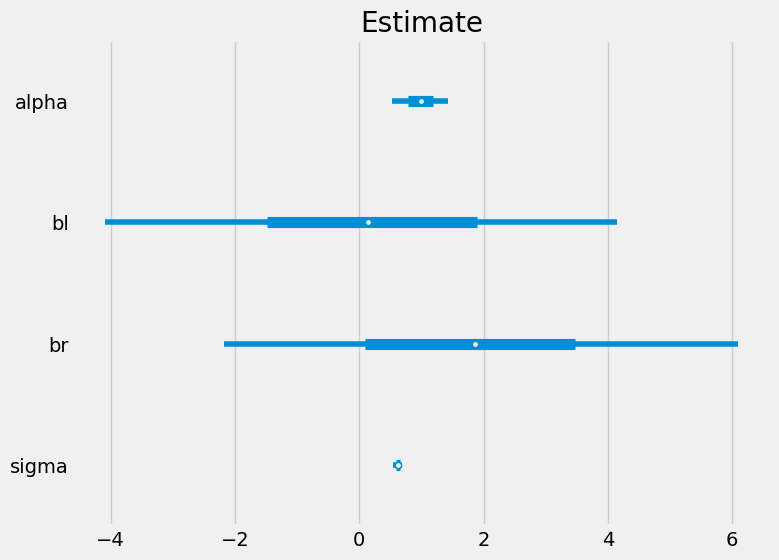

In [7]:
#@title 6.4
fig,ax = plt.subplots(1,1,figsize=(8,6))
az.plot_forest(
data = {"alpha":df_post_samples_m_6_1['alpha'].values,"bl":df_post_samples_m_6_1['bl'].values,
        "br": df_post_samples_m_6_1['br'].values,
           "sigma":df_post_samples_m_6_1['sigma'].values },
hdi_prob=0.89,
ax=ax,
var_names=["alpha","bl","br","sigma"],

)
ax.set_title('Estimate')
plt.show()

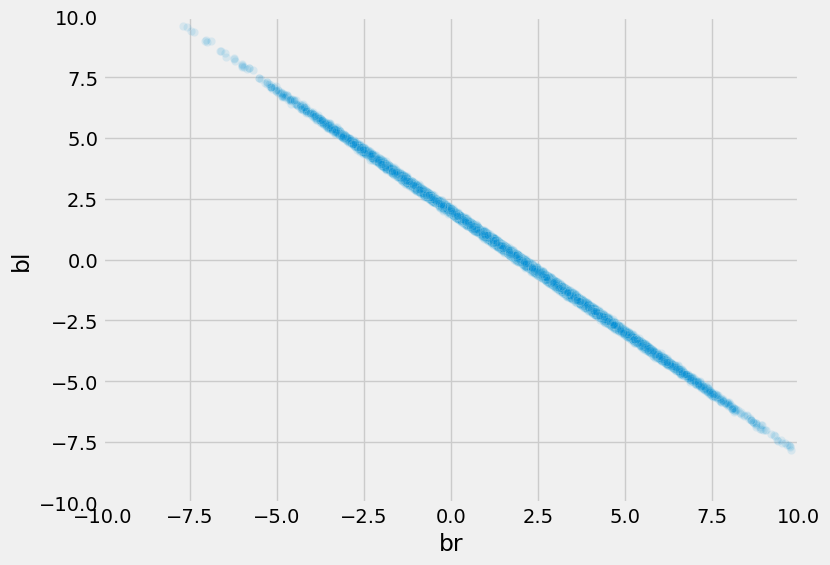

In [8]:
#@title 6.5
fig,axs = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x='br', y='bl',  data=df_post_samples_m_6_1, alpha=0.1,
                legend=False, ax=axs)
axs.set_xlim(-10,10)
axs.set_ylim(-10,10)
axs.set_xlabel('br')
axs.set_ylabel('bl')
plt.show()

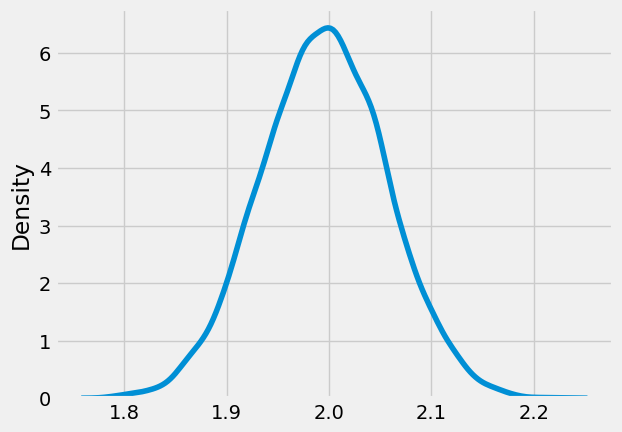

In [9]:
#@title 6.6
sum_blbr = df_post_samples_m_6_1['bl'] + df_post_samples_m_6_1['br']
sns.kdeplot(sum_blbr)
plt.show()

In [10]:
#@title 6.7
leg_left_arr = jnp.array(d['leg_left'])
leg_right_arr = jnp.array(d['leg_right'])
height_arr = jnp.array(d['height'])

model6_2 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=1.0,scale=0.5),
    bl = tfd.Normal(loc=2,scale=0.1),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda alpha,bl: tfd.Deterministic(alpha + bl * leg_left_arr),
    h = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_2(parameters):
  samples = model6_2.sample(
      h = height_arr,
      alpha = parameters[0],
      bl = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_2.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_2,method='L-BFGS-B')
alpha_start = model6_2.parameters['model']['alpha'].mean()
bl_start = model6_2.parameters['model']['bl'].mean()
sigma_start = model6_2.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bl_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_6_2 = marginal_test_results(model6_2,results,nll6_2)
df_result.round(2)

,mean,sd,low,high
alpha,0.99,0.22,0.64,1.34
bl,1.99,0.05,1.92,2.07
sigma,0.62,0.04,0.55,0.69


In [11]:
#@title 6.8
milk = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/milk.csv',sep= ';')
d = milk.copy()
display(d.info())
d.head()
d["K"] = d['kcal.per.g'].pipe(lambda x: (x - x.mean())/x.std())
d["F"] = d['perc.fat'].pipe(lambda x: (x - x.mean())/x.std())
d["L"] = d['perc.lactose'].pipe(lambda x: (x - x.mean())/x.std())

K_arr = jnp.array(d.K)
F_arr = jnp.array(d.F)
L_arr = jnp.array(d.L)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


None

In [12]:
#@title 6.9
model6_3 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    a = tfd.Normal(loc=0.0,scale=0.2),
    bF = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda a,bF: tfd.Deterministic(a + bF * F_arr),
    K = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_3(parameters):
  samples = model6_3.sample(
      K = K_arr,
      a = parameters[0],
      bF = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_3.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll6_3,method='L-BFGS-B')
a_start = model6_3.parameters['model']['a'].mean()
bF_start = model6_3.parameters['model']['bF'].mean()
sigma_start = 2.0

results = optimize_fn.run(init_params=jnp.array([a_start,bF_start,sigma_start]))
df_result_m_6_3,cov_matrix,df_post_samples_m_6_3 = marginal_test_results(model6_3,results,nll6_3)
df_result_m_6_3.round(2)


,mean,sd,low,high
a,0.00,0.08,-0.12,0.12
bF,0.86,0.08,0.73,1.00
sigma,0.45,0.06,0.36,0.54


In [13]:
#@title 6.9
model6_4 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    a = tfd.Normal(loc=0.0,scale=0.2),
    bL = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda a,bL: tfd.Deterministic(a + bL * L_arr),
    K = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_4(parameters):
  samples = model6_4.sample(
      K = K_arr,
      a = parameters[0],
      bL = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_4.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll6_4,method='L-BFGS-B')
a_start = model6_4.parameters['model']['a'].mean()
bL_start = model6_4.parameters['model']['bL'].mean()
sigma_start = 2.0

results = optimize_fn.run(init_params=jnp.array([a_start,bL_start,sigma_start]))
df_result_m_6_4,cov_matrix,df_post_samples_m_6_4 = marginal_test_results(model6_4,results,nll6_4)
df_result_m_6_4.round(2)

,mean,sd,low,high
a,-0.00,0.07,-0.11,0.11
bL,-0.90,0.07,-1.02,-0.79
sigma,0.38,0.05,0.30,0.46


In [14]:
#@title 6.10
model6_5 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    a = tfd.Normal(loc=0.0,scale=0.2),
    bL = tfd.Normal(loc=0.0,scale=0.5),
    bF = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda a,bL,bF: tfd.Deterministic(a + bL * L_arr + bF * F_arr),
    K = lambda mu,sigma: tfd.Normal(mu,sigma)
)
)
def nll6_5(parameters):
  samples = model6_5.sample(
      K = K_arr,
      a = parameters[0],
      bL = parameters[1],
      bF = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model6_5.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_5,method='L-BFGS-B')
a_start = model6_5.parameters['model']['a'].mean()
bL_start = model6_5.parameters['model']['bL'].mean()
bF_start = model6_5.parameters['model']['bF'].mean()
sigma_start = model6_5.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([a_start,bL_start,bF_start,sigma_start]))
df_result_m_6_5,cov_matrix,df_post_samples_m_6_5 = marginal_test_results(model6_5,results,nll6_5)
df_result_m_6_5.round(2)

,mean,sd,low,high
a,-0.00,0.07,-0.11,0.11
bL,-0.68,0.18,-0.97,-0.38
bF,0.24,0.18,-0.05,0.54
sigma,0.38,0.05,0.30,0.46


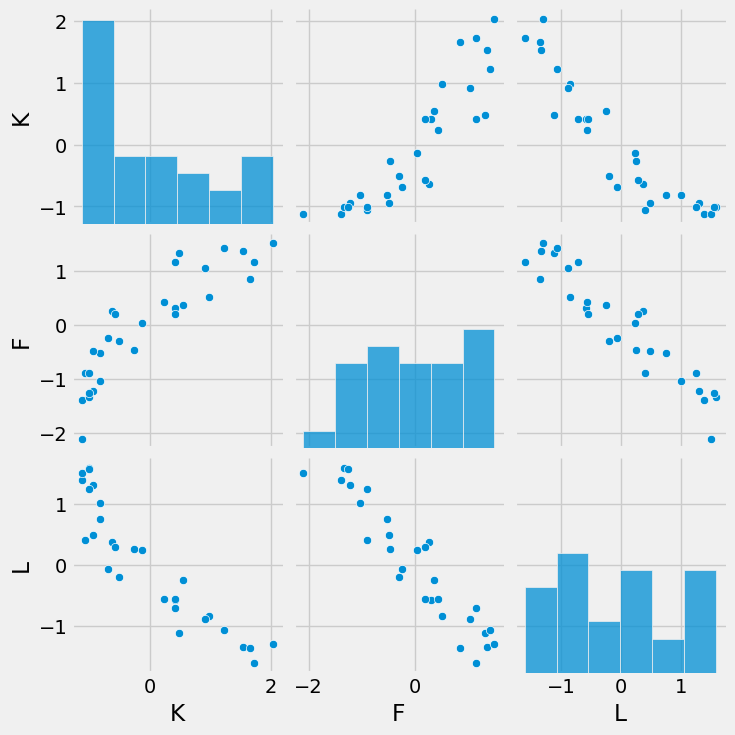

In [15]:
#@title 6.11
sns.pairplot(d[['K','F','L']])
fig.show()

In [16]:
d1 = d.copy()
d1.rename(columns= {"kcal.per.g":"kcal_per_g","perc.fat":"perc_fat"},inplace=True)
d1.head()

,clade,species,kcal_per_g,perc_fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


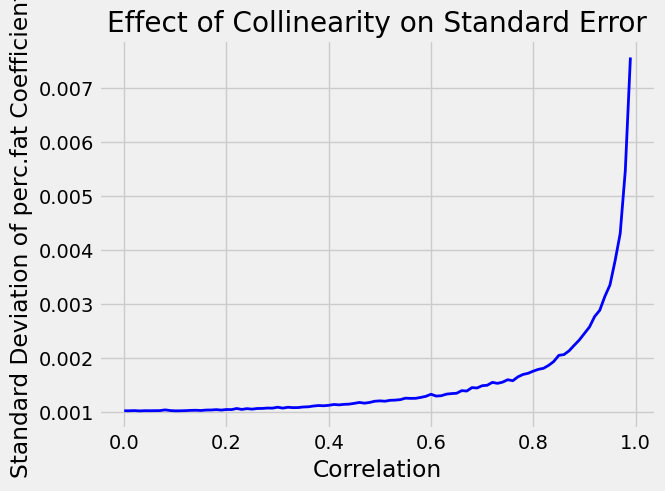

In [17]:
#@title 6.12 [consider changing the code. Extremly slow as of now]
def sim_coll(r=0.9):
  """Simulates correlated variable and fits a linear model."""
  d1['x'] = np.random.normal(loc=r * d1['perc_fat'],
                            scale=np.sqrt((1 - r**2) * np.var(d1['perc_fat'])),
                            size=len(d1))
  model = smf.ols('kcal_per_g ~ perc_fat + x', data=d1).fit()
  return np.sqrt(np.diag(model.cov_params()))[1]  # Stddev of perc.fat coeff

def rep_sim_coll(r=0.9, n=100):
  """Repeats the simulation and calculates the mean standard deviation."""
  stddevs = [sim_coll(r) for _ in range(n)]
  return np.mean(stddevs)

r_seq = np.arange(0, 1, 0.01)
stddevs = [rep_sim_coll(r=z, n=100) for z in r_seq]

plt.plot(r_seq, stddevs, linestyle='-', color='blue', linewidth=2)
plt.xlabel('Correlation')
plt.ylabel('Standard Deviation of perc.fat Coefficient')
plt.title('Effect of Collinearity on Standard Error')
plt.show()

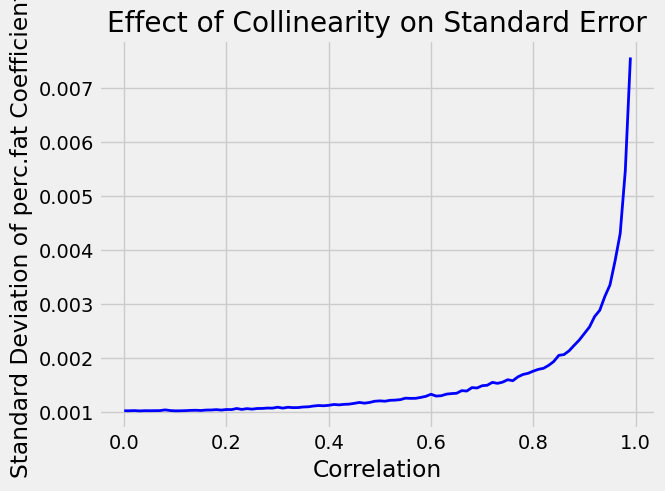

In [18]:
#@title 6.12 [This is much faster]
from scipy.optimize import curve_fit
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.plot(r_seq, stddevs, linestyle='-', color='blue', linewidth=2)
plt.xlabel('Correlation')
plt.ylabel('Standard Deviation of perc.fat Coefficient')
plt.title('Effect of Collinearity on Standard Error')
plt.show()

In [19]:
# This is using np.vectorize but that is slow as well
# def sim_coll(r=0.9):
#   """Simulates correlated variable and fits a linear model."""
#   d1['x'] = np.random.normal(loc=r * d1['perc_fat'],
#                             scale=np.sqrt((1 - r**2) * np.var(d1['perc_fat'])),
#                             size=len(d1))
#   model = smf.ols('kcal_per_g ~ perc_fat + x', data=d1).fit()
#   return np.sqrt(np.diag(model.cov_params()))[1]  # Stddev of perc.fat coeff

# def rep_sim_coll(r=0.9, n=100):
#   """Repeats the simulation and calculates the mean standard deviation."""
#   v_sim_roll = np.vectorize(sim_coll)
#   array_n = np.repeat(r, n)
#   stddevs = v_sim_roll(array_n)
#   return np.mean(stddevs)

# v_rep_sim = np.vectorize(rep_sim_coll)
# r_seq = np.arange(0, 1, 0.01)
# stddevs = v_rep_sim(r=r_seq, n=100)


# plt.plot(r_seq, stddevs, linestyle='-', color='blue', linewidth=2)  # 'rangi2' replaced with blue
# plt.xlabel('Correlation')
# plt.ylabel('Standard Deviation of perc.fat Coefficient')
# plt.title('Effect of Collinearity on Standard Error')
# plt.show()



In [20]:
#@title 6.13
N = 100
# simulate initial heights
h0 = stats.norm.rvs(loc = 10,scale = 2,size = N)
# assign treatment and simulate fungus and growth
treatment = np.concatenate([np.zeros(50),np.ones(50)])
# 0.5 - treatment*0.4
fungus = stats.binom.rvs(1, p = 0.5 - treatment*0.4)
h1 = h0 + stats.norm.rvs(loc = 5 - 3*fungus,scale =1)
d= pd.DataFrame({'h0':h0,'h1':h1,'treatment':treatment,'fungus':fungus})
d.describe()

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.633532,13.747337,0.500000,0.320000
std,1.832061,2.245755,0.502519,0.468826
min,5.639072,7.360573,0.000000,0.000000
25%,8.518387,12.338585,0.000000,0.000000
50%,9.693281,13.590993,0.500000,0.000000
75%,10.744477,15.387430,1.000000,1.000000
max,16.656917,20.679545,1.000000,1.000000


In [21]:
#@title reading data from book
import io
import pandas as pd
d=pd.read_csv(io.StringIO('''
h0,h1,treatment,fungus
9.136316,14.345788,0,0
9.105626,15.623924,0,0
9.042855,14.386665,0,0
10.834291,15.837422,0,0
9.164199,11.469124,0,1
7.625672,11.107757,0,0
7.855429,10.719927,0,1
12.006568,17.860526,0,0
7.783043,9.64772,0,1
12.526861,16.472809,0,0
10.585901,12.500246,0,1
11.09655,15.689399,0,0
8.26669,10.779174,0,1
9.579474,15.978794,0,0
8.94567,13.6897,0,0
6.757244,12.274612,0,0
11.65787,14.612659,0,1
11.562659,15.746473,0,0
9.782177,11.41943,0,1
9.848021,11.260161,0,1
9.370316,13.764445,0,0
6.427792,11.071513,0,0
9.519831,14.866884,0,0
10.236252,14.804618,0,0
6.486194,10.923358,0,0
6.035933,10.551913,0,0
10.525574,11.066042,0,1
13.348238,18.521596,0,0
9.879829,15.492026,0,0
10.81246,16.408409,0,0
10.801174,12.446595,0,1
7.007481,9.157068,0,1
9.123739,13.158071,0,0
10.139669,14.098734,0,0
9.978441,10.751478,0,1
9.441272,16.434371,0,0
12.970572,17.410952,0,0
12.886556,16.737634,0,1
12.380928,14.347588,0,1
10.414104,15.632942,0,0
8.934501,13.390932,0,0
11.738026,13.600482,0,1
5.592808,6.057598,0,1
8.01858,10.700429,0,1
9.564466,12.211672,0,1
7.545683,7.936819,0,1
10.249442,14.425274,0,0
9.475606,13.921112,0,0
7.982438,12.447915,0,0
9.932372,15.617196,0,0
7.514281,13.128628,1,0
14.179036,17.958292,1,0
12.472595,14.950532,1,1
9.540242,16.240725,1,0
9.095851,14.788849,1,0
12.758704,16.181501,1,0
11.851902,17.455585,1,0
12.671088,15.896264,1,0
10.448354,17.626031,1,0
7.584858,11.6908,1,0
14.182318,17.7025,1,0
10.335658,17.300716,1,0
12.486711,18.056423,1,0
16.251765,21.979133,1,0
13.909934,18.448249,1,0
9.530831,15.777977,1,0
8.77306,13.765626,1,0
9.706493,15.268086,1,0
9.609992,12.248596,1,1
12.288041,17.805365,1,0
10.783307,15.469561,1,0
11.935213,16.178844,1,0
8.932954,15.213742,1,0
8.235359,12.823,1,0
11.186016,16.444509,1,0
7.211482,12.212834,1,0
9.171769,14.381935,1,0
12.164331,17.000799,1,0
8.688027,13.99259,1,0
10.028956,13.187817,1,1
8.601324,13.842718,1,0
12.362746,17.769125,1,0
10.071638,14.237424,1,0
12.026649,18.30057,1,0
9.338934,14.808016,1,0
12.588285,17.273129,1,0
10.562037,15.476398,1,0
11.036701,17.298185,1,0
9.5554,15.878521,1,0
13.165464,17.903015,1,0
9.227042,16.381273,1,0
6.675259,13.632934,1,0
5.818838,9.213313,1,1
9.724274,16.921325,1,0
11.944584,16.351148,1,0
6.781211,12.058563,1,0
9.015878,13.764293,1,0
5.811263,11.799564,1,0
8.20936,12.804295,1,0
9.948589,13.653099,1,0
'''), header=0)
d.describe()

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.959780,14.399204,0.500000,0.230000
std,2.101162,2.688087,0.502519,0.422953
min,5.592808,6.057598,0.000000,0.000000
25%,8.892981,12.447585,0.000000,0.000000
50%,9.753225,14.518967,0.500000,0.000000
75%,11.586462,16.358679,1.000000,0.000000
max,16.251765,21.979133,1.000000,1.000000


In [22]:
#@title 6.14
sim_p = stats.lognorm.rvs(s=0.25,loc = 0.0, scale =1, size = 10000)
sim_p
az.hdi(sim_p, hdi_prob = 0.89)

array([0.61787215, 1.41106157])

In [23]:
h0_arr = jnp.array(d['h0'])
h1_arr = jnp.array(d['h1'])
treatment_arr = jnp.array(d['treatment'])
fungus_arr = jnp.array(d['fungus'])

In [24]:
#@title 6.15
model6_6 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    p = tfd.LogNormal(loc = 0.0,scale = 0.25),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda p: tfd.Deterministic(p * h0_arr),
    h1 = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
)
)
def nll6_6(parameters):
  samples = model6_6.sample(
      h1 = h1_arr,
      p = parameters[0],
      sigma = parameters[1],
      seed = jax.random.PRNGKey(42))
  return -1* model6_6.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_6,method='L-BFGS-B')
p_start = model6_6.parameters['model']['p'].mean()
sigma_start = model6_6.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([p_start,sigma_start]))
df_result_m_6_6,cov_matrix,df_post_samples_m_6_6 = marginal_test_results(model6_6,results,nll6_6)
df_result_m_6_6.round(2)

,mean,sd,low,high
p,1.43,0.02,1.40,1.45
sigma,1.79,0.13,1.59,1.99


In [25]:
#@title 6.16
model6_7 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.LogNormal(loc = 0.0,scale = 0.2),
    beta_T = tfd.Normal(loc = 0, scale = 0.5),
    beta_F = tfd.Normal(loc = 0, scale = 0.5),
    sigma = tfd.Exponential(rate = 1.0),
    p = lambda alpha,beta_T,beta_F : tfd.Deterministic(alpha + beta_T * treatment_arr + beta_F * fungus_arr),
    h1 = lambda p,sigma: tfd.Normal(loc=p * h0_arr,scale=sigma)
)
)
def nll6_7(parameters):
  samples = model6_7.sample(
      h1 = h1_arr,
      alpha = parameters[0],
      beta_T = parameters[1],
      beta_F = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model6_7.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_7,method='L-BFGS-B')
alpha_start = model6_7.parameters['model']['alpha'].mean()
beta_T_start = model6_7.parameters['model']['beta_T'].mean()
beta_F_start = model6_7.parameters['model']['beta_F'].mean()
sigma_start = model6_7.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,beta_T_start,beta_F_start,sigma_start]))
df_result_m_6_7,cov_matrix,df_post_samples_m_6_7 = marginal_test_results(model6_7,results,nll6_7)
df_result_m_6_7.round(2)

,mean,sd,low,high
alpha,1.48,0.02,1.44,1.52
beta_T,0.00,0.03,-0.05,0.05
beta_F,-0.27,0.04,-0.33,-0.21
sigma,1.41,0.10,1.25,1.57


In [30]:
#@title 6.17
model6_8 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.LogNormal(loc = 0.0, scale = 0.2),
    beta_T = tfd.Normal(loc = 0, scale = 0.5),
    sigma = tfd.Exponential(rate = 1.0),
    p = lambda alpha,beta_T : tfd.Deterministic(alpha + beta_T * treatment_arr),
    h1 = lambda p,sigma: tfd.Normal(loc=p * h0_arr,scale=sigma)
)
)
def nll6_8(parameters):
  samples = model6_8.sample(
      h1 = h1_arr,
      alpha = parameters[0],
      beta_T = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_8.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_8,method='L-BFGS-B')
alpha_start = model6_8.parameters['model']['alpha'].mean()
beta_T_start = model6_8.parameters['model']['beta_T'].mean()
sigma_start = model6_8.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,beta_T_start,sigma_start]))
df_result_m_6_8,cov_matrix,df_post_samples_m_6_8 = marginal_test_results(model6_8,results,nll6_8)
df_result_m_6_8.round(2)

,mean,sd,low,high
alpha,1.38,0.03,1.34,1.42
beta_T,0.09,0.03,0.03,0.14
sigma,1.75,0.12,1.55,1.94


In [32]:
#@title reading the same data
import io
import pandas as pd
d2 = pd.read_csv(io.StringIO('''
h0,h1,treatment,fungus
9.136315628,14.79491487,0,0
9.105625647,15.27635405,0,0
9.042854825,16.38223565,0,1
10.83429081,19.064849,0,1
9.16419872,17.20835987,0,1
7.625672162,13.35067114,0,0
7.855428937,16.19634733,0,1
12.00656769,18.31947783,0,1
7.78304349,12.45307282,0,0
12.52686144,21.61559903,0,1
10.58590146,18.2481926,0,1
11.09655003,19.02028354,0,1
8.266690277,16.27681575,0,1
9.579473951,19.29656466,0,1
8.945669864,16.67389271,0,1
6.75724398,15.53078659,0,1
11.65787009,16.22467828,0,1
11.56265893,19.53710758,0,0
9.782177105,17.34676011,0,1
9.848021035,14.78260128,0,0
9.37031562,16.93128358,0,1
6.427791921,15.05645699,0,1
9.519831258,13.6824773,0,1
10.23625221,18.82851522,0,1
6.48619359,13.99799985,0,1
6.035933487,11.88898372,0,1
10.52557378,16.31222211,0,0
13.34823788,19.71699767,0,0
9.879828719,17.35607986,0,1
10.81245983,15.78943054,0,1
10.80117405,18.08998935,0,1
7.007480598,12.81058781,0,1
9.123738686,14.68493446,0,1
10.1396691,15.64236991,0,1
9.978441469,13.38687694,0,0
9.441271607,17.40166226,0,1
12.97057202,17.38638506,0,1
12.88655643,17.42421331,0,1
12.38092836,19.70825189,0,1
10.41410425,14.98718183,0,0
8.93450143,13.47649325,0,1
11.73802615,18.48123985,0,1
5.592807581,12.28414229,0,1
8.018579648,18.29399547,0,1
9.564466281,14.76882473,0,0
7.545683219,12.30319943,0,0
10.24944209,18.29280007,0,1
9.475606,14.96042579,0,1
7.982437921,13.67659046,0,1
9.932371597,18.58120906,0,1
7.514280833,11.66084392,0,1
14.1790363,16.28800756,0,0
12.47259515,18.02968941,0,1
9.540241891,17.53664556,0,1
9.09585101,14.5354372,0,0
12.75870402,21.31297049,0,1
11.85190169,19.67632348,0,1
12.67108816,18.24767695,0,1
10.44835358,15.0357371,0,1
7.584858251,13.95415959,0,0
14.18231778,23.23922142,0,1
10.33565798,18.54457256,0,1
12.48671083,16.83118165,0,0
16.25176478,21.03185979,0,1
13.90993371,19.38223771,0,1
9.530831268,16.03107522,0,0
8.773060287,16.63491229,0,1
9.706493034,17.59403499,0,1
9.609991827,14.77964173,0,1
12.28804125,16.45507014,0,0
10.78330658,18.48953109,0,1
11.93521325,17.32872303,0,0
8.932954379,14.08241402,0,0
8.235359398,15.09239793,0,1
11.18601646,16.84880541,0,0
7.211482156,8.448005563,0,1
9.171769429,15.86641947,0,0
12.16433102,19.80454035,0,1
8.688027084,16.36192994,0,1
10.02895578,18.82933353,0,1
8.601323849,17.74046294,0,1
12.36274649,20.45572279,0,1
10.07163789,18.32896606,0,0
12.02664936,16.69612964,0,1
9.338933631,17.209244,0,1
12.58828461,22.8588326,0,1
10.56203721,18.03016738,0,1
11.03670077,18.62428608,0,1
9.555399543,17.13958361,0,0
13.1654637,21.38755754,0,1
9.227041991,15.15495428,0,0
6.675259235,14.71782447,0,0
5.818837898,12.0066927,0,0
9.724273792,14.98961927,0,0
11.94458412,21.39693853,0,1
6.781210575,14.20692605,0,1
9.015878289,16.87262735,0,0
5.811263197,14.3488903,0,1
8.209359893,13.54587154,0,0
9.948588569,19.13800127,0,0
9.042537632,17.8760418,0,1
7.677409632,12.21260486,0,1
11.94899791,16.54555021,0,1
11.02132986,16.64891315,0,1
11.0718885,16.16463708,0,0
12.07351068,20.1940762,0,0
12.2345587,17.45967141,0,1
8.506842423,16.30001822,0,0
13.73921259,20.86212372,0,1
14.54989302,23.0715095,0,0
7.827214744,16.28926396,0,1
9.207137457,13.31555409,0,0
9.632823254,17.40193889,0,1
11.10474135,16.18273293,0,1
9.207168544,14.17175971,0,1
10.63221539,20.56169601,0,1
9.578835905,18.11491417,0,1
11.01735179,18.3895632,0,1
8.464732962,13.66218657,0,1
10.35747623,14.8064822,0,1
9.334150445,16.84416852,0,1
11.54277812,15.59646727,0,1
10.74812008,18.65000854,0,1
9.404334146,15.79158059,0,1
9.170081678,15.27136875,0,1
9.571483133,16.49984219,0,1
13.12861445,20.49351127,0,1
9.092198427,13.85497599,0,1
12.3658653,19.41339569,0,1
8.675698494,17.24382792,0,1
7.004208116,15.49184929,0,1
7.275680943,13.14953208,0,0
9.756382539,14.35150006,0,0
9.368509404,18.28207515,0,1
12.64787601,17.92409749,0,0
11.32991441,16.70561172,0,0
7.408275105,15.69529093,0,1
7.506549888,13.98836828,0,1
12.10017163,21.1089906,0,1
11.60178024,18.59346524,0,1
8.970804579,13.86180843,0,1
12.15792432,19.52961672,0,1
6.987780648,11.73001638,0,1
10.15109832,15.54667387,0,1
12.29821352,18.87083743,0,1
10.71283695,18.58480073,0,1
13.36505737,18.85008646,0,0
6.175169937,13.6871984,0,1
11.52103089,18.4268755,0,1
8.888390023,11.15512028,0,1
10.4189455,17.73383154,0,0
13.0365963,20.99024858,0,1
10.68762075,20.23788006,0,1
10.00626255,14.50186906,0,0
10.60985138,17.00468983,0,1
6.96416948,15.27123585,0,1
11.72899704,16.3323708,0,1
11.70791726,14.9331556,0,0
9.729353814,18.84048075,0,0
7.891895829,12.91195831,0,0
9.828688687,15.91521759,0,1
9.185698449,16.30822293,0,1
11.02496684,16.45341115,0,1
12.79863956,18.56147693,0,1
9.488061057,13.05490702,0,0
11.03473522,15.43999387,0,1
11.90957694,17.72633682,0,1
8.367627534,15.14758461,0,1
9.274505999,12.85139954,0,0
8.824280689,16.77550006,0,1
8.788259388,13.11195014,0,1
9.287442534,16.41999522,0,1
10.69410455,17.99440092,0,1
9.136730749,15.01845217,0,1
8.874328245,14.61543939,0,1
9.031959136,16.5975799,0,1
7.080935463,16.232581,0,1
10.34671648,20.06368046,0,0
11.22439552,18.48621444,0,1
11.19189899,19.42524312,0,1
9.290841828,18.20726155,0,1
10.299174,17.67587314,0,1
8.068664413,12.97970542,0,1
7.918129575,13.40540902,0,0
7.546072533,13.46616571,0,1
13.98619938,23.0284337,0,1
8.880759034,16.62236093,0,1
13.70215425,19.15541021,0,1
9.933318623,15.9297768,0,1
10.43767559,20.14415989,0,1
8.912860474,17.15565381,0,1
9.724912471,16.0140589,0,1
6.929580272,12.15004513,0,1
11.36369772,16.15390992,0,0
11.29441056,19.29296398,0,1
6.782271024,13.93616298,0,1
8.351664808,13.759691,0,1
8.891011858,12.68629464,0,0
8.930953366,14.39938212,0,0
11.36964791,18.57283912,0,1
11.22869433,20.35309558,0,0
7.558510969,15.45818611,0,1
10.955873,17.06723244,0,0
13.40096535,18.56722629,0,1
11.38599618,16.24032816,0,0
6.845594946,11.44220808,0,1
11.20736597,19.79319272,0,1
6.450350944,11.6308228,0,0
14.35535451,20.31853562,0,0
8.211883929,15.43812339,0,1
7.040365405,14.09167055,0,1
13.93011637,19.52990878,0,1
11.13942434,16.23101719,0,1
11.45473582,15.76913861,0,0
9.076630065,13.14385864,0,1
12.49429145,18.58974296,0,1
9.985132256,18.44387297,0,1
11.12318685,17.59811971,0,1
11.27720923,17.10640081,0,0
11.03464739,19.06681621,0,1
9.372509671,17.91739662,0,1
8.487261536,15.59274096,0,1
12.56157559,20.27711456,0,0
9.175282095,16.09857857,0,1
10.51698536,18.83247988,0,1
10.00270417,19.67435548,0,1
10.42033022,19.1709167,0,1
9.6729352,18.9633251,0,0
10.60912676,19.19546563,0,1
12.31772319,20.23820732,0,1
10.4827875,17.66950326,0,1
10.81275683,14.10191545,0,1
8.331572525,13.1174163,0,0
12.54784076,17.43211398,0,1
10.93816565,15.36511391,0,1
9.369688935,15.80520924,0,1
9.828720753,19.38228125,0,1
12.52296921,17.32603291,0,0
12.64624206,20.35308638,0,1
9.475103262,16.66560495,0,1
14.30846252,19.03668841,0,0
13.91534914,19.99485107,0,1
12.78894943,17.01343477,0,1
14.39410311,24.07426984,0,1
8.813128639,13.30469117,0,0
10.55470404,15.43564759,0,1
9.49682963,15.42483808,0,0
11.97660127,16.92142745,0,0
9.189870092,14.9561644,0,1
7.409020145,15.31827699,0,1
10.99102246,16.20875249,0,1
10.34237631,15.84708901,0,0
9.148182052,17.70134017,0,1
9.664183848,15.653414,0,0
7.882257691,11.84310384,0,0
9.140936996,15.9479384,0,1
10.2631591,14.39096582,0,1
9.739122068,14.80554459,0,1
11.46271524,19.06796701,0,1
9.768584588,18.70015214,0,1
11.30385339,16.7361368,0,1
9.769737757,19.73376876,0,1
11.72227401,17.67390514,0,0
8.362725819,17.72882311,0,1
8.347056415,17.84854525,0,1
8.668363183,17.00450485,0,1
12.89171759,16.52941735,0,0
11.58330658,16.14950494,0,0
14.76175145,20.2742795,0,0
13.38846142,22.0344352,0,1
6.326707898,9.726637392,0,1
10.64390895,19.65948423,0,1
12.1511403,17.47821096,0,0
10.7610274,15.31428438,0,0
8.554962746,14.69159576,0,0
10.20344438,18.50219851,0,1
9.422018248,17.20291282,0,1
10.27904856,18.20541104,0,0
9.121330401,15.4325771,0,0
9.218959083,17.54658934,0,1
8.386043631,14.48870116,0,0
10.76839169,14.18691513,0,0
10.13573857,18.42015997,0,1
11.54113238,16.93313981,0,0
9.025766012,14.34356694,0,0
9.3864126,16.1065746,0,1
13.40976768,18.6926359,0,1
14.04475886,17.3471154,0,0
9.82895673,18.56290392,0,1
12.58721518,17.81238511,0,1
8.794211255,14.02839076,0,1
7.470976605,14.68612863,0,0
13.7710547,22.42106449,0,1
11.0388725,15.83602293,0,1
9.849731973,14.40315423,0,1
6.944149153,12.71599508,0,0
6.951119815,15.42092799,0,1
9.524174604,13.95145227,0,0
9.937859856,17.63475921,0,1
11.52663186,19.05273859,0,1
8.789634543,17.55770111,0,1
10.30903406,15.30063396,0,1
12.37086795,20.72219267,0,1
14.21895554,22.25638952,0,1
9.982113284,15.29965772,0,0
8.485025892,16.78222235,0,1
10.56051866,16.74621645,0,1
8.723103913,17.16192485,0,1
10.28395054,16.56189007,0,0
9.499572369,14.58962359,0,1
9.360321313,12.98816609,0,0
10.4459753,15.9773082,0,0
11.66279221,17.7237736,0,1
8.799776648,13.93405535,0,0
7.004283132,16.15892178,0,1
12.1766242,18.5026142,0,0
7.586235837,15.06680587,0,1
8.87876234,13.28509326,0,1
10.66683742,15.69162782,0,1
14.047427,18.45032102,0,1
14.45688192,18.95223169,0,1
9.974749377,17.55836532,0,1
11.12968972,18.27491744,0,1
14.16700643,18.87005387,0,0
9.547177063,13.64155066,0,1
9.90071971,12.81328057,0,0
8.049144156,14.74655061,0,1
10.03068707,16.17019409,0,1
8.92449995,17.8355679,0,1
12.24250702,19.97034642,0,1
10.37052746,18.05921041,0,1
12.45352222,17.39578235,0,0
9.758752988,18.14827026,0,1
11.45701943,21.08285108,0,0
14.0672577,23.42508612,0,1
11.70459269,17.82341241,0,0
12.47678042,22.24011622,0,1
8.158946912,15.54063155,0,1
10.26351743,18.83118894,0,1
10.31076849,15.96909512,0,1
10.74403286,18.26861148,0,1
9.135220225,14.11684891,0,1
12.67606085,17.49674652,0,0
9.656515681,17.63627626,0,1
9.444615866,14.94238203,0,0
9.661296529,18.11679835,0,1
10.83529944,19.83790783,0,1
6.009695366,10.86644316,0,1
8.058207211,15.74007787,0,1
11.06959802,15.59844765,0,1
10.6402763,16.48423247,0,1
12.46675344,18.81727629,0,0
10.0881861,17.16041126,0,1
8.096975514,15.02633727,0,1
9.062582847,14.59064052,0,1
5.721949735,14.34245007,0,1
9.442253924,18.78578778,0,1
9.924151316,16.28253193,0,0
11.65782994,17.94744671,0,1
4.686604057,12.82598494,0,1
7.802168165,12.12622127,0,1
11.50180075,15.06821415,0,0
11.1398237,19.10120014,0,1
9.075735089,14.3012874,0,1
7.493863179,13.54287016,0,1
9.819959066,20.12432038,0,1
12.40562889,20.966759,0,1
10.31865525,16.19724229,0,0
9.242177963,14.6313871,0,1
9.049027947,15.85889247,0,1
8.821659319,14.32320746,0,1
9.473668044,16.01732773,0,1
9.500622717,14.98573107,0,1
11.80609385,20.2352659,0,1
10.94043305,14.22562017,0,1
9.428080287,18.67080288,0,1
7.933469344,16.15206067,0,0
9.488956774,16.84098346,0,1
13.86059205,19.70598803,0,1
12.66943242,20.30182349,0,1
10.56162847,15.30483991,0,0
7.241171597,13.35318536,0,0
10.66820096,17.07401096,0,1
7.325350963,14.77266702,0,1
12.3664051,17.79092627,0,0
13.03896351,21.33361823,0,1
9.595992036,14.39709243,0,1
13.0114336,18.75676796,0,0
9.282801438,14.8108622,0,0
10.91420465,16.62946149,0,1
10.84115255,14.75197239,0,1
9.73319098,12.25366142,0,1
10.05743167,15.09854422,0,1
8.375607663,13.11554483,0,0
8.457680349,17.94128178,0,0
12.42629625,19.80897534,0,1
9.777900225,14.66002236,0,1
9.343381179,14.40581099,0,0
11.90236256,15.63442615,0,0
9.544947285,16.61451364,0,1
4.575824236,11.08773152,0,1
14.58553345,18.89236151,0,0
8.139551395,13.80784802,0,1
8.326146028,17.32831269,0,1
9.159820919,13.31620551,0,1
9.65345439,17.02497771,0,1
10.56856982,16.5794302,0,0
9.120035343,18.60665305,0,1
8.690506418,17.14699125,0,1
8.171898797,13.66541477,0,1
12.3277624,18.35254817,0,1
10.78535954,16.08057563,0,0
11.00477411,18.29030262,0,1
10.24358993,19.38212778,0,1
10.54451826,18.14837545,0,1
9.053708527,13.67523249,0,0
11.10033807,19.22284551,0,1
10.92061103,18.64338477,0,1
9.613636436,17.70614963,0,1
6.816587588,10.99726969,0,1
9.995328233,17.78866026,0,1
12.89261789,16.74739732,0,0
8.884525594,13.52515907,0,1
6.09985664,11.0324272,0,0
11.70789178,15.30335655,0,1
12.24288825,16.83492277,0,1
6.168662772,12.30243636,0,0
10.19419185,14.73556886,0,0
10.57688971,16.07764192,0,1
9.658974324,16.33226129,0,1
10.56872137,18.16289141,0,1
11.92947555,19.26278277,0,1
7.401808805,15.01909018,0,1
7.534355802,11.22634358,0,0
10.30793082,18.50523098,0,1
7.146590409,14.09064106,0,1
9.088712164,13.66619303,0,0
12.84161775,20.97796655,0,1
10.64088125,17.06107259,0,1
10.32951217,14.92562262,0,0
10.03985092,19.45278007,0,1
10.42498263,17.54364364,0,0
9.034111437,13.71410276,0,1
10.14171858,18.39711488,0,1
8.111271318,12.68017282,0,0
11.61452052,17.07014104,0,0
12.37498069,21.63668006,0,1
12.40518612,21.80880882,0,1
11.70583399,22.23894353,0,1
7.771940671,15.56232111,0,1
8.272650328,12.71448335,0,1
10.18866042,18.3369452,0,0
10.27232499,14.75855868,0,1
11.75007668,20.26173043,0,0
8.122606577,13.70641234,0,1
10.16016132,16.36072432,0,1
8.495084856,17.93076936,0,1
11.48271001,15.90467253,0,1
10.93792508,18.99598091,0,1
13.52265323,22.95637236,0,1
8.246894738,18.01289292,0,1
8.117747288,13.33385113,0,1
12.47257973,16.36937375,0,1
9.823660627,18.83645738,0,1
8.842783664,13.99423942,0,1
12.06285986,19.40914475,0,1
11.04974679,15.47613231,0,1
9.754730595,15.93266373,0,0
9.341676052,15.86526348,0,1
11.04550815,18.81842877,0,1
10.88716313,17.87920438,0,1
11.19834946,19.25926093,0,1
6.214367384,10.44655069,0,0
10.50103934,17.63403242,0,1
11.6632678,16.9785074,0,0
6.901044922,14.47947288,0,1
13.02921284,21.00184177,0,1
10.95526271,18.06722375,0,1
11.48148162,18.55088773,0,1
11.79197106,19.23348829,0,1
9.060174373,17.35106613,0,1
10.59947972,20.20352213,0,1
10.57297592,15.76909342,0,0
10.86311044,19.21971334,0,0
13.88979786,21.05507708,0,1
6.847053113,15.08292725,0,1
14.48106205,22.40153554,0,1
8.948157309,17.3152698,0,1
11.43164613,20.08454899,0,1
9.758590969,14.00464196,0,0
6.168380466,13.75974464,0,1
10.04685849,17.08631178,0,1
10.23089731,16.29114862,0,1
8.143570313,15.8376207,0,1
9.928747076,16.01330547,0,0
9.105415137,17.93117688,0,1
11.37916015,16.66647193,0,1
15.16066035,19.45570246,0,0
9.950623022,14.45596949,0,1
11.27549963,18.56722398,0,1
11.3927421,19.50809616,1,1
7.892911183,11.14462912,1,0
10.29200924,16.9147048,1,1
8.135077192,15.76553583,1,1
6.845889492,14.17543508,1,0
9.500456664,15.16092296,1,0
11.7726166,15.37586837,1,0
8.954872466,15.17101387,1,1
10.66594476,15.99918237,1,1
12.36749474,15.83301634,1,0
10.30044797,17.55116526,1,1
10.51827235,18.88727598,1,0
9.64547426,17.88169876,1,0
8.932591937,15.3090497,1,0
9.744137346,16.42630802,1,0
11.28928878,15.31199984,1,0
11.62488885,14.84374318,1,0
12.9116415,23.33315413,1,0
7.196952237,13.6076284,1,0
10.54950096,16.53265844,1,0
12.504707,20.12359775,1,0
9.132744531,14.57004229,1,0
10.70684447,18.16861609,1,0
9.570895573,17.65503507,1,1
7.341816568,11.93795708,1,0
8.67329624,16.7814284,1,1
12.87141831,19.60070492,1,0
10.98712256,15.36400679,1,0
7.725468662,13.31559674,1,0
9.493475267,13.86050133,1,0
10.66711246,13.76486297,1,0
13.48222414,17.72560285,1,0
9.477178722,14.11447561,1,0
11.95104981,16.34990893,1,0
12.69469047,19.35937021,1,0
7.860974143,16.50407422,1,1
10.48125316,15.32240326,1,0
9.195255796,17.84296979,1,0
9.726567899,15.52289992,1,0
11.30681646,16.19950528,1,0
7.545487545,11.99492049,1,0
8.773442248,11.15156096,1,0
9.020046914,15.16405007,1,0
10.32946304,16.58426877,1,0
12.09867684,20.65237404,1,1
10.65317752,17.35349186,1,0
10.66891857,17.11398203,1,0
8.270510047,13.54139682,1,0
9.327601829,14.75623656,1,1
9.312725909,17.05340903,1,0
12.93225186,18.5655481,1,0
9.206152898,15.80448118,1,1
10.95214626,19.20838483,1,0
10.44566174,18.63060411,1,0
5.745300998,11.89975251,1,0
11.70042248,17.10102713,1,0
9.651006816,17.34191449,1,0
8.408627086,15.62804532,1,1
11.98271703,17.25568563,1,0
7.403983627,13.12807868,1,0
5.074082489,14.60757181,1,1
11.51245426,21.07379291,1,0
9.789445259,17.21077571,1,1
4.164705786,13.04039146,1,0
11.58545651,15.74703611,1,1
9.939810691,15.0911023,1,0
10.39217655,18.53730543,1,1
11.624627,21.93067172,1,1
10.74046255,17.58681853,1,0
7.213742639,14.01522617,1,1
9.906247837,17.35692063,1,1
13.09069349,20.83401271,1,1
10.52315112,16.69206938,1,0
13.65079298,20.26584647,1,0
11.34852035,16.78448657,1,0
8.022854582,13.92144891,1,0
11.69897943,18.40850099,1,1
11.02430067,16.13438082,1,0
10.10842409,18.40176423,1,0
7.578208387,12.64809791,1,0
10.3178342,15.69866354,1,0
8.319062835,14.75516024,1,0
8.670107992,13.61347472,1,0
10.54925102,14.00622531,1,0
10.79789903,17.92752568,1,0
7.005766688,15.53658367,1,1
9.712005031,14.45228918,1,0
8.850199212,16.65724545,1,1
7.265708534,15.81572261,1,0
11.74839985,16.68970699,1,0
9.788885103,14.78038104,1,0
10.59575953,14.77568845,1,0
11.38841513,14.98444202,1,0
11.35665322,16.32970928,1,1
4.367963331,11.39027759,1,1
10.70351269,14.99882297,1,0
12.08249914,20.90200706,1,0
8.62469199,13.50327507,1,0
9.287275419,16.82023336,1,0
8.010088232,16.67738786,1,0
13.30936926,19.81283155,1,0
9.933020495,16.76290316,1,1
12.06057892,19.39361586,1,0
8.517747967,12.80169793,1,0
8.063194028,11.82020131,1,0
10.82804827,21.06830646,1,0
13.42847218,21.92116039,1,1
8.935209924,14.57255175,1,0
10.50530597,16.85993315,1,1
8.809359626,11.65581385,1,0
10.6596884,17.09682344,1,0
14.62573821,25.20956133,1,1
6.866972196,12.8810224,1,0
10.1585521,15.77232098,1,0
11.69565679,17.34581599,1,0
10.1468774,16.35800321,1,0
12.2242755,19.94378688,1,0
10.04032806,14.56371006,1,0
14.46714501,19.08899807,1,0
10.55568345,16.6676669,1,0
10.18844553,13.69996956,1,0
11.67393686,19.60958621,1,0
8.650666513,12.54044483,1,0
10.51882109,19.73633153,1,0
7.575095481,12.32195837,1,1
8.70724337,14.66177172,1,0
11.73272665,17.40241997,1,1
10.02331508,14.78138176,1,0
7.274994914,12.42229953,1,0
11.87754189,18.28044242,1,1
11.01758622,20.08259755,1,0
13.28689215,18.16706223,1,0
9.351482316,14.78521027,1,1
10.62482838,16.37123229,1,1
10.73944416,16.09915819,1,0
7.555787945,14.97170497,1,0
11.98770529,15.98797373,1,0
10.64743475,15.60088381,1,0
9.124736886,18.72733374,1,0
11.43282478,17.18247953,1,0
8.747792254,17.48469662,1,0
7.57665355,14.01769651,1,0
11.38465239,18.23999989,1,0
10.62847637,13.95089511,1,0
8.891785535,16.34992333,1,1
9.767202707,19.56056141,1,1
7.907884315,12.83255035,1,0
10.211673,17.03821581,1,0
9.482531678,17.62932911,1,1
9.028253283,17.11148177,1,1
10.58370346,18.81834264,1,0
12.89451068,20.34952163,1,0
10.81007373,14.48924708,1,0
13.02019577,21.20932453,1,0
15.66370173,26.24092284,1,1
11.79207658,19.7299908,1,1
10.11662956,17.1337522,1,0
11.25724692,17.97528951,1,0
9.744659614,16.55306184,1,1
7.344484141,12.17340504,1,0
12.25434008,16.75734522,1,0
15.02285881,21.89878886,1,1
10.25689138,17.64662211,1,0
6.453214045,12.56098318,1,1
15.21613478,18.02311099,1,0
7.805489899,16.8728544,1,1
9.120322041,14.12897992,1,0
9.380712388,17.71025979,1,1
8.498578709,17.04619155,1,1
8.086081314,15.44395992,1,1
8.819942202,16.03871688,1,0
14.58604335,20.23856503,1,0
10.37042267,19.28510856,1,0
9.688552413,15.86159216,1,0
8.973439347,15.93522264,1,0
11.39443721,19.20066444,1,1
11.74171903,20.49945735,1,1
7.555012155,12.29832236,1,0
10.36870096,16.83756762,1,0
7.898041355,12.37876218,1,0
10.10833919,15.9694498,1,0
10.83958013,18.41601539,1,1
10.93164355,18.13149566,1,0
10.2608274,17.52524854,1,1
10.13108232,13.8294705,1,0
8.662153195,11.76568576,1,0
10.85482645,15.34823452,1,0
9.493100319,17.87446202,1,0
13.10018751,18.59824511,1,0
6.361430873,13.74392389,1,1
13.19777036,22.07024746,1,1
7.761330286,13.11961409,1,0
8.938888506,13.25199134,1,1
8.298596444,15.37346194,1,0
9.544692285,14.82039688,1,0
10.27738993,14.43999044,1,0
7.804418326,15.44654803,1,1
10.81883974,16.2344912,1,0
11.66989411,21.72388519,1,0
6.910165122,15.62391876,1,1
11.90510277,16.44272954,1,0
11.03668199,19.90443936,1,1
10.66510379,16.83061729,1,0
7.117736462,13.4695502,1,0
9.658808936,16.81099975,1,0
13.98740765,19.71100807,1,0
12.64315372,16.94403619,1,1
13.43227902,17.29429435,1,0
10.78081316,18.01542096,1,0
14.07823846,20.18685949,1,0
9.593530363,15.83201239,1,0
11.82864677,18.9995041,1,1
13.0005849,18.09554349,1,0
12.54978485,18.79894439,1,0
10.09533354,18.08756855,1,0
11.63421174,19.41370708,1,1
6.823685249,14.15090161,1,1
8.84479192,13.45113367,1,0
12.34989124,21.60203373,1,1
9.331880824,12.55189913,1,0
8.070171802,15.57380665,1,0
11.14650681,19.74266629,1,0
11.63804806,15.87456661,1,0
10.09013068,15.59321276,1,0
8.609566902,18.72785691,1,1
7.943235081,16.363944,1,0
10.11897438,16.87545861,1,0
7.155851489,16.45558047,1,1
10.69688404,15.74982651,1,0
11.10770343,17.54909417,1,0
7.786028111,14.04817033,1,1
12.10878038,17.72438861,1,0
8.24641292,12.06002,1,0
11.02911334,18.8876926,1,0
11.32671733,15.95455454,1,0
9.367413318,15.24773619,1,0
7.959816079,15.52610789,1,1
6.409999644,14.97176363,1,0
7.303225726,17.05505925,1,1
9.731204789,16.91709837,1,1
11.01302174,19.80107956,1,0
7.543523971,12.74812097,1,0
10.37351036,16.8162889,1,0
10.79083579,17.75858823,1,1
6.443172548,13.91066864,1,0
9.005453006,14.15553441,1,1
9.696876477,17.49409155,1,0
10.00878161,19.7429821,1,0
11.83000112,16.03246041,1,0
6.927901166,16.12223939,1,0
14.51571545,18.53984179,1,0
13.28219024,18.13760598,1,0
10.60848908,14.3703655,1,0
8.942197196,16.63236798,1,1
8.202914404,16.68831334,1,0
8.058327529,17.77038145,1,0
14.54097305,19.97500182,1,0
13.0186062,18.57017163,1,0
12.12132283,17.81953409,1,0
6.317377698,10.92881234,1,0
7.058448551,15.12400985,1,1
7.943765569,15.7178759,1,1
6.500212785,15.56462224,1,1
6.1790227,10.56893769,1,0
10.931828,17.07852341,1,0
9.426272645,19.28103544,1,0
6.21696816,14.71901847,1,0
11.21229787,15.01497282,1,0
9.597826693,15.08348078,1,0
10.60131002,17.80547266,1,1
10.69045084,18.49919426,1,0
10.68981214,18.62894769,1,0
9.56505381,14.79847533,1,0
8.224482256,14.78841884,1,0
12.55965158,17.2996375,1,0
9.68202034,16.0166498,1,1
8.556498014,16.39933359,1,1
14.22835926,19.69943012,1,0
9.84215866,16.72429056,1,0
7.256101415,15.00460816,1,1
6.580510077,13.31291045,1,0
11.54282721,19.98603823,1,0
9.460938801,13.11895896,1,0
11.6224161,15.75590729,1,1
7.368407723,14.75506341,1,1
9.841001901,18.08442061,1,1
9.385667073,15.92892664,1,1
9.539126327,16.09924918,1,1
10.46966389,16.6712153,1,0
10.67104231,17.29362977,1,0
11.65304461,16.12602613,1,0
12.03472937,16.73952821,1,0
6.429717007,14.79508079,1,1
11.09328386,15.31040199,1,0
11.9196176,17.15206755,1,0
8.712787778,13.23198705,1,0
10.67582028,13.82933742,1,0
8.944269314,12.51744472,1,0
8.811646241,17.6512879,1,1
9.466218913,14.3498629,1,0
14.30686182,23.20982793,1,1
8.296937152,10.7188951,1,0
5.460323803,10.91197076,1,0
7.625434508,15.36305335,1,1
7.864860218,16.70000226,1,0
11.20581424,19.67533232,1,0
13.25664172,17.60178838,1,0
10.96828061,16.24606735,1,0
9.233224051,16.86706,1,1
8.679984817,16.98762855,1,1
13.16327417,17.84117498,1,1
11.76949303,17.30926203,1,0
8.519949123,13.2557122,1,0
12.16095589,21.48062135,1,1
11.26413743,17.56086235,1,0
6.999551065,14.96282997,1,1
6.586245614,11.35598454,1,0
10.28954221,18.61221291,1,0
9.718607805,15.29765237,1,1
13.63677524,17.82612721,1,0
10.26407913,16.65505004,1,0
10.54269244,16.49384775,1,0
10.14635776,16.65023289,1,0
9.569723175,15.24898038,1,0
13.94053655,20.91392561,1,1
14.13380686,17.6369667,1,0
10.10114914,13.46424929,1,0
8.750707747,13.27345264,1,0
13.30742072,21.9298648,1,1
8.558706487,14.48169483,1,0
10.83050748,17.9417758,1,0
12.23640428,18.62738071,1,1
9.372432921,18.11687885,1,1
12.89608388,18.72429833,1,0
10.67802787,19.01515991,1,1
11.89758889,20.52829527,1,0
8.422646748,13.6930716,1,0
11.61449239,17.50684676,1,0
11.59726225,19.71242484,1,0
11.14186904,16.85568043,1,0
9.786260734,16.38826056,1,0
11.0241859,14.50556741,1,0
11.5341886,19.6192626,1,0
14.17874021,20.59875599,1,0
9.734602026,13.8467413,1,0
11.40437581,17.0438696,1,1
10.06020892,14.76998129,1,0
9.71356587,17.74518214,1,1
8.225218853,15.28987034,1,0
11.74531327,21.47465916,1,0
7.036244314,10.20985938,1,0
7.497009516,15.18168064,1,0
13.11635578,20.31460586,1,0
13.0611389,21.39508325,1,1
6.971949576,14.63367316,1,0
10.33385543,18.85164187,1,1
11.5265225,16.87505393,1,0
9.181276429,14.41567547,1,0
8.295487683,17.40043916,1,0
11.30698853,18.04334216,1,0
7.230748709,14.31332369,1,1
10.15082326,15.29930067,1,0
8.044860599,15.47690055,1,0
8.668593819,13.31880359,1,0
10.09318537,17.99177645,1,1
9.174413539,18.46037648,1,0
6.914420119,11.79335003,1,0
9.742100154,17.76966397,1,1
10.90697506,15.84359974,1,0
9.954713016,14.38001548,1,0
12.90932203,19.70017038,1,1
9.550911084,17.51095598,1,1
10.65820659,14.86964854,1,0
10.23964936,18.83465152,1,1
9.461985038,16.96068116,1,0
7.423662402,16.46350331,1,1
11.33426495,18.35727969,1,0
9.864192782,18.64486769,1,1
6.932267323,12.84397281,1,0
8.995965324,15.71715706,1,0
9.939798664,14.94781081,1,0
9.144428971,13.46798241,1,0
8.588329641,16.90927132,1,0
7.698973974,12.63353372,1,0
6.793535766,11.69043374,1,0
8.978348397,16.68369452,1,0
13.71792605,22.91168555,1,1
9.193448913,13.53426861,1,0
6.375030322,13.22869732,1,1
10.159441,15.59165595,1,0
7.206621824,12.22201527,1,0
9.114261749,15.5841492,1,0
8.964745406,14.28188534,1,0
9.738686451,17.94095503,1,0
12.93710224,22.79419163,1,1
10.3551555,20.90741597,1,0
12.02084857,19.03449432,1,1
14.1715845,22.02548543,1,1
15.39362011,20.42589584,1,0
8.446221585,12.80666666,1,0
11.39654117,19.05629111,1,0
8.178991949,14.19161316,1,0
9.749589506,12.82654521,1,0
11.80947807,16.55316506,1,0
10.0822939,14.52662434,1,0
8.004899425,13.74840483,1,0
10.9436594,16.66382361,1,0
11.35639738,15.27395543,1,1
12.67449634,19.46210232,1,0
9.722715204,17.09621241,1,1
14.23447351,21.48612929,1,1
11.83392582,20.46839845,1,1
12.92980675,22.24528466,1,1
11.53987077,20.94468534,1,0
11.48549901,20.13163284,1,0
12.60254694,19.98419619,1,1
6.938694237,15.55962311,1,1
11.34476381,17.22078376,1,0
6.404119566,14.88802703,1,0
13.94327253,19.81106399,1,0
14.09303505,18.87631293,1,0
10.6986248,15.59105337,1,1
7.262368324,10.98077816,1,0
11.32553497,19.49171784,1,0
9.561788231,16.56111342,1,0
11.12844588,16.50071279,1,0
6.246588961,14.67119446,1,1
10.9310742,16.09586156,1,0
12.2789794,16.39830075,1,0
8.138487908,18.12946704,1,0
9.674386087,14.51253505,1,0
11.04052677,18.11695765,1,0
10.73504093,19.37449766,1,1
10.4315915,18.52401076,1,1
8.152759208,13.65350956,1,0
9.83373668,13.91684257,1,0
7.468690115,13.80293106,1,0
12.68351248,19.99831546,1,1
8.824026239,15.06753723,1,0
7.000341473,11.60660398,1,0
10.47357772,18.03935331,1,1
10.34300568,18.45528248,1,1
6.931751612,13.49679414,1,0
10.38065048,17.7562494,1,1
9.437176462,13.32848837,1,0
11.44550167,16.73762981,1,0
11.58582674,16.82836925,1,0
13.92344482,18.0804323,1,0
11.00361618,19.10243258,1,0
8.340324992,14.19514179,1,0
13.59222018,22.07540119,1,1
9.750013321,15.06404477,1,0
9.847154064,13.71256981,1,0
9.254789747,15.65394051,1,1
12.6137507,21.09644017,1,1
9.355921559,16.96218846,1,0
10.52923194,18.75330256,1,0
8.792321696,13.08314641,1,0
9.299084876,13.95411415,1,0
8.861464131,13.87184391,1,1
8.34314603,15.11852569,1,1
10.79140745,15.22984457,1,1
9.122824088,14.36220992,1,0
10.18225128,15.61752094,1,0
9.675718693,15.85229663,1,0
5.69343435,13.67443729,1,1
11.46610973,18.99414518,1,0
8.404582289,18.08570487,1,1
8.601501514,14.97116068,1,0
9.82360932,13.65950988,1,0
13.16678068,21.04716977,1,1
8.650800916,14.64391514,1,0
10.14155631,16.49639826,1,0
9.58740063,14.72041064,1,1
12.3300809,19.88079619,1,0
10.66870862,15.50530415,1,0
10.54881132,18.74681978,1,0
10.77427165,19.52028501,1,1
10.5029008,19.28993997,1,1
8.48667817,12.56097521,1,0
10.32295675,14.62514848,1,0
7.972411967,12.45392059,1,0
10.4604332,18.04399487,1,0
13.16954388,17.00778559,1,0
10.07374657,15.68715026,1,1
10.58504222,16.65880933,1,0
8.06837182,17.12033881,1,0
9.332900651,14.85185826,1,0
11.55145213,19.74316447,1,1
8.935283906,19.91310791,1,1
11.18129323,18.64546385,1,1
9.931620837,16.73773125,1,0
10.10914843,14.55033258,1,0
12.5729705,21.18991518,1,0
9.713997059,17.40159057,1,1
11.47437831,16.20012675,1,0
17.48698691,26.98019475,1,1
12.13323225,16.42071879,1,0
7.417728164,15.09487098,1,0
8.196527423,16.21107596,1,0
'''), header=0)


In [33]:
d2.head()

,h0,h1,treatment,fungus
0,9.136316,14.794915,0,0
1,9.105626,15.276354,0,0
2,9.042855,16.382236,0,1
3,10.834291,19.064849,0,1
4,9.164199,17.208360,0,1


In [35]:
#@title 6.20
h0_arr = jnp.array(d2['h0'])
h1_arr = jnp.array(d2['h1'])
treatment_arr = jnp.array(d2['treatment'])
fungus_arr = jnp.array(d2['fungus'])

model6_7 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.LogNormal(loc = 0.0,scale = 0.2),
    beta_T = tfd.Normal(loc = 0, scale = 0.5),
    beta_F = tfd.Normal(loc = 0, scale = 0.5),
    sigma = tfd.Exponential(rate = 1.0),
    p = lambda alpha,beta_T,beta_F : tfd.Deterministic(alpha + beta_T * treatment_arr + beta_F * fungus_arr),
    h1 = lambda p,sigma: tfd.Normal(loc=p * h0_arr,scale=sigma)
)
)
def nll6_7(parameters):
  samples = model6_7.sample(
      h1 = h1_arr,
      alpha = parameters[0],
      beta_T = parameters[1],
      beta_F = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model6_7.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_7,method='L-BFGS-B')
alpha_start = model6_7.parameters['model']['alpha'].mean()
beta_T_start = model6_7.parameters['model']['beta_T'].mean()
beta_F_start = model6_7.parameters['model']['beta_F'].mean()
sigma_start = model6_7.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,beta_T_start,beta_F_start,sigma_start]))
df_result_m_6_7,cov_matrix,df_post_samples_m_6_7 = marginal_test_results(model6_7,results,nll6_7)
df_result_m_6_7.round(2)

,mean,sd,low,high
alpha,1.52,0.01,1.50,1.54
beta_T,0.05,0.01,0.03,0.07
beta_F,0.14,0.01,0.12,0.17
sigma,2.10,0.05,2.03,2.18


In [36]:
#@title 6.20
model6_8 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.LogNormal(loc = 0.0, scale = 0.2),
    beta_T = tfd.Normal(loc = 0, scale = 0.5),
    sigma = tfd.Exponential(rate = 1.0),
    p = lambda alpha,beta_T : tfd.Deterministic(alpha + beta_T * treatment_arr),
    h1 = lambda p,sigma: tfd.Normal(loc=p * h0_arr,scale=sigma)
)
)
def nll6_8(parameters):
  samples = model6_8.sample(
      h1 = h1_arr,
      alpha = parameters[0],
      beta_T = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_8.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_8,method='L-BFGS-B')
alpha_start = model6_8.parameters['model']['alpha'].mean()
beta_T_start = model6_8.parameters['model']['beta_T'].mean()
sigma_start = model6_8.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,beta_T_start,sigma_start]))
df_result_m_6_8,cov_matrix,df_post_samples_m_6_8 = marginal_test_results(model6_8,results,nll6_8)
df_result_m_6_8.round(2)

,mean,sd,low,high
alpha,1.62,0.01,1.61,1.64
beta_T,-0.01,0.01,-0.03,0.01
sigma,2.21,0.05,2.13,2.28


In [45]:
#@title reading the marriage and age simulation data
import io
import pandas as pd
d=pd.read_csv(io.StringIO('''
age,married,happiness
65,0,-2
65,0,-1.789473684
65,1,-1.578947368
65,0,-1.368421053
65,0,-1.157894737
65,0,-0.9473684211
65,1,-0.7368421053
65,1,-0.5263157895
65,0,-0.3157894737
65,0,-0.1052631579
65,1,0.1052631579
65,1,0.3157894737
65,1,0.5263157895
65,1,0.7368421053
65,0,0.9473684211
65,1,1.157894737
65,1,1.368421053
65,1,1.578947368
65,1,1.789473684
65,1,2
64,0,-2
64,0,-1.789473684
64,0,-1.578947368
64,0,-1.368421053
64,0,-1.157894737
64,0,-0.9473684211
64,0,-0.7368421053
64,1,-0.5263157895
64,0,-0.3157894737
64,0,-0.1052631579
64,1,0.1052631579
64,1,0.3157894737
64,1,0.5263157895
64,1,0.7368421053
64,0,0.9473684211
64,1,1.157894737
64,1,1.368421053
64,1,1.578947368
64,1,1.789473684
64,1,2
63,0,-2
63,0,-1.789473684
63,1,-1.578947368
63,0,-1.368421053
63,0,-1.157894737
63,0,-0.9473684211
63,0,-0.7368421053
63,1,-0.5263157895
63,0,-0.3157894737
63,0,-0.1052631579
63,0,0.1052631579
63,1,0.3157894737
63,1,0.5263157895
63,1,0.7368421053
63,1,0.9473684211
63,1,1.157894737
63,1,1.368421053
63,1,1.578947368
63,1,1.789473684
63,1,2
62,0,-2
62,0,-1.789473684
62,0,-1.578947368
62,0,-1.368421053
62,1,-1.157894737
62,0,-0.9473684211
62,0,-0.7368421053
62,1,-0.5263157895
62,1,-0.3157894737
62,0,-0.1052631579
62,1,0.1052631579
62,0,0.3157894737
62,1,0.5263157895
62,1,0.7368421053
62,1,0.9473684211
62,1,1.157894737
62,1,1.368421053
62,1,1.578947368
62,1,1.789473684
62,1,2
61,0,-2
61,0,-1.789473684
61,0,-1.578947368
61,0,-1.368421053
61,1,-1.157894737
61,0,-0.9473684211
61,0,-0.7368421053
61,0,-0.5263157895
61,1,-0.3157894737
61,0,-0.1052631579
61,1,0.1052631579
61,0,0.3157894737
61,1,0.5263157895
61,1,0.7368421053
61,1,0.9473684211
61,1,1.157894737
61,1,1.368421053
61,1,1.578947368
61,1,1.789473684
61,1,2
60,0,-2
60,0,-1.789473684
60,1,-1.578947368
60,1,-1.368421053
60,0,-1.157894737
60,0,-0.9473684211
60,0,-0.7368421053
60,0,-0.5263157895
60,1,-0.3157894737
60,1,-0.1052631579
60,1,0.1052631579
60,0,0.3157894737
60,1,0.5263157895
60,0,0.7368421053
60,1,0.9473684211
60,1,1.157894737
60,1,1.368421053
60,1,1.578947368
60,1,1.789473684
60,1,2
59,0,-2
59,0,-1.789473684
59,0,-1.578947368
59,0,-1.368421053
59,1,-1.157894737
59,0,-0.9473684211
59,0,-0.7368421053
59,1,-0.5263157895
59,0,-0.3157894737
59,1,-0.1052631579
59,0,0.1052631579
59,1,0.3157894737
59,1,0.5263157895
59,1,0.7368421053
59,1,0.9473684211
59,1,1.157894737
59,1,1.368421053
59,1,1.578947368
59,1,1.789473684
59,1,2
58,0,-2
58,1,-1.789473684
58,1,-1.578947368
58,0,-1.368421053
58,0,-1.157894737
58,1,-0.9473684211
58,0,-0.7368421053
58,1,-0.5263157895
58,0,-0.3157894737
58,1,-0.1052631579
58,1,0.1052631579
58,1,0.3157894737
58,0,0.5263157895
58,1,0.7368421053
58,0,0.9473684211
58,1,1.157894737
58,1,1.368421053
58,1,1.578947368
58,1,1.789473684
58,1,2
57,0,-2
57,0,-1.789473684
57,0,-1.578947368
57,0,-1.368421053
57,0,-1.157894737
57,0,-0.9473684211
57,0,-0.7368421053
57,1,-0.5263157895
57,0,-0.3157894737
57,1,-0.1052631579
57,1,0.1052631579
57,1,0.3157894737
57,1,0.5263157895
57,0,0.7368421053
57,1,0.9473684211
57,1,1.157894737
57,1,1.368421053
57,1,1.578947368
57,1,1.789473684
57,1,2
56,0,-2
56,0,-1.789473684
56,0,-1.578947368
56,0,-1.368421053
56,0,-1.157894737
56,1,-0.9473684211
56,1,-0.7368421053
56,1,-0.5263157895
56,0,-0.3157894737
56,0,-0.1052631579
56,0,0.1052631579
56,1,0.3157894737
56,1,0.5263157895
56,1,0.7368421053
56,1,0.9473684211
56,1,1.157894737
56,1,1.368421053
56,1,1.578947368
56,1,1.789473684
56,1,2
55,0,-2
55,0,-1.789473684
55,0,-1.578947368
55,0,-1.368421053
55,0,-1.157894737
55,0,-0.9473684211
55,0,-0.7368421053
55,0,-0.5263157895
55,0,-0.3157894737
55,1,-0.1052631579
55,1,0.1052631579
55,0,0.3157894737
55,1,0.5263157895
55,1,0.7368421053
55,1,0.9473684211
55,1,1.157894737
55,0,1.368421053
55,1,1.578947368
55,1,1.789473684
55,1,2
54,0,-2
54,0,-1.789473684
54,1,-1.578947368
54,0,-1.368421053
54,1,-1.157894737
54,0,-0.9473684211
54,1,-0.7368421053
54,0,-0.5263157895
54,1,-0.3157894737
54,1,-0.1052631579
54,1,0.1052631579
54,1,0.3157894737
54,1,0.5263157895
54,1,0.7368421053
54,1,0.9473684211
54,1,1.157894737
54,1,1.368421053
54,1,1.578947368
54,1,1.789473684
54,1,2
53,0,-2
53,0,-1.789473684
53,0,-1.578947368
53,0,-1.368421053
53,0,-1.157894737
53,0,-0.9473684211
53,0,-0.7368421053
53,1,-0.5263157895
53,0,-0.3157894737
53,0,-0.1052631579
53,0,0.1052631579
53,1,0.3157894737
53,0,0.5263157895
53,1,0.7368421053
53,1,0.9473684211
53,1,1.157894737
53,1,1.368421053
53,1,1.578947368
53,1,1.789473684
53,1,2
52,0,-2
52,0,-1.789473684
52,1,-1.578947368
52,0,-1.368421053
52,0,-1.157894737
52,0,-0.9473684211
52,0,-0.7368421053
52,0,-0.5263157895
52,1,-0.3157894737
52,1,-0.1052631579
52,1,0.1052631579
52,1,0.3157894737
52,1,0.5263157895
52,1,0.7368421053
52,1,0.9473684211
52,0,1.157894737
52,1,1.368421053
52,1,1.578947368
52,1,1.789473684
52,1,2
51,0,-2
51,0,-1.789473684
51,0,-1.578947368
51,0,-1.368421053
51,1,-1.157894737
51,0,-0.9473684211
51,0,-0.7368421053
51,0,-0.5263157895
51,1,-0.3157894737
51,1,-0.1052631579
51,1,0.1052631579
51,0,0.3157894737
51,1,0.5263157895
51,1,0.7368421053
51,1,0.9473684211
51,1,1.157894737
51,1,1.368421053
51,1,1.578947368
51,1,1.789473684
51,1,2
50,0,-2
50,0,-1.789473684
50,0,-1.578947368
50,0,-1.368421053
50,1,-1.157894737
50,1,-0.9473684211
50,0,-0.7368421053
50,0,-0.5263157895
50,0,-0.3157894737
50,0,-0.1052631579
50,0,0.1052631579
50,0,0.3157894737
50,0,0.5263157895
50,1,0.7368421053
50,1,0.9473684211
50,0,1.157894737
50,1,1.368421053
50,1,1.578947368
50,1,1.789473684
50,1,2
49,0,-2
49,0,-1.789473684
49,1,-1.578947368
49,0,-1.368421053
49,1,-1.157894737
49,0,-0.9473684211
49,0,-0.7368421053
49,0,-0.5263157895
49,1,-0.3157894737
49,0,-0.1052631579
49,0,0.1052631579
49,1,0.3157894737
49,1,0.5263157895
49,0,0.7368421053
49,0,0.9473684211
49,1,1.157894737
49,1,1.368421053
49,1,1.578947368
49,0,1.789473684
49,1,2
48,0,-2
48,0,-1.789473684
48,0,-1.578947368
48,1,-1.368421053
48,1,-1.157894737
48,0,-0.9473684211
48,0,-0.7368421053
48,0,-0.5263157895
48,0,-0.3157894737
48,0,-0.1052631579
48,0,0.1052631579
48,1,0.3157894737
48,1,0.5263157895
48,0,0.7368421053
48,1,0.9473684211
48,1,1.157894737
48,1,1.368421053
48,1,1.578947368
48,1,1.789473684
48,1,2
47,0,-2
47,0,-1.789473684
47,0,-1.578947368
47,0,-1.368421053
47,0,-1.157894737
47,0,-0.9473684211
47,0,-0.7368421053
47,0,-0.5263157895
47,0,-0.3157894737
47,1,-0.1052631579
47,0,0.1052631579
47,1,0.3157894737
47,1,0.5263157895
47,1,0.7368421053
47,1,0.9473684211
47,1,1.157894737
47,1,1.368421053
47,1,1.578947368
47,0,1.789473684
47,1,2
46,0,-2
46,0,-1.789473684
46,0,-1.578947368
46,0,-1.368421053
46,1,-1.157894737
46,0,-0.9473684211
46,1,-0.7368421053
46,1,-0.5263157895
46,1,-0.3157894737
46,0,-0.1052631579
46,1,0.1052631579
46,1,0.3157894737
46,0,0.5263157895
46,1,0.7368421053
46,1,0.9473684211
46,1,1.157894737
46,1,1.368421053
46,1,1.578947368
46,1,1.789473684
46,1,2
45,1,-2
45,0,-1.789473684
45,0,-1.578947368
45,0,-1.368421053
45,0,-1.157894737
45,0,-0.9473684211
45,0,-0.7368421053
45,0,-0.5263157895
45,0,-0.3157894737
45,0,-0.1052631579
45,1,0.1052631579
45,1,0.3157894737
45,0,0.5263157895
45,1,0.7368421053
45,1,0.9473684211
45,1,1.157894737
45,1,1.368421053
45,1,1.578947368
45,1,1.789473684
45,1,2
44,0,-2
44,0,-1.789473684
44,0,-1.578947368
44,0,-1.368421053
44,0,-1.157894737
44,1,-0.9473684211
44,0,-0.7368421053
44,0,-0.5263157895
44,0,-0.3157894737
44,1,-0.1052631579
44,1,0.1052631579
44,0,0.3157894737
44,0,0.5263157895
44,1,0.7368421053
44,1,0.9473684211
44,1,1.157894737
44,1,1.368421053
44,1,1.578947368
44,1,1.789473684
44,1,2
43,0,-2
43,0,-1.789473684
43,0,-1.578947368
43,0,-1.368421053
43,0,-1.157894737
43,0,-0.9473684211
43,1,-0.7368421053
43,0,-0.5263157895
43,0,-0.3157894737
43,0,-0.1052631579
43,0,0.1052631579
43,0,0.3157894737
43,1,0.5263157895
43,0,0.7368421053
43,0,0.9473684211
43,0,1.157894737
43,1,1.368421053
43,0,1.578947368
43,1,1.789473684
43,1,2
42,0,-2
42,0,-1.789473684
42,0,-1.578947368
42,0,-1.368421053
42,0,-1.157894737
42,0,-0.9473684211
42,0,-0.7368421053
42,0,-0.5263157895
42,0,-0.3157894737
42,0,-0.1052631579
42,1,0.1052631579
42,1,0.3157894737
42,1,0.5263157895
42,1,0.7368421053
42,0,0.9473684211
42,0,1.157894737
42,1,1.368421053
42,1,1.578947368
42,1,1.789473684
42,1,2
41,0,-2
41,0,-1.789473684
41,0,-1.578947368
41,0,-1.368421053
41,0,-1.157894737
41,0,-0.9473684211
41,1,-0.7368421053
41,0,-0.5263157895
41,0,-0.3157894737
41,0,-0.1052631579
41,0,0.1052631579
41,0,0.3157894737
41,1,0.5263157895
41,0,0.7368421053
41,1,0.9473684211
41,1,1.157894737
41,1,1.368421053
41,1,1.578947368
41,1,1.789473684
41,1,2
40,0,-2
40,0,-1.789473684
40,0,-1.578947368
40,0,-1.368421053
40,1,-1.157894737
40,0,-0.9473684211
40,0,-0.7368421053
40,1,-0.5263157895
40,0,-0.3157894737
40,1,-0.1052631579
40,1,0.1052631579
40,1,0.3157894737
40,0,0.5263157895
40,1,0.7368421053
40,0,0.9473684211
40,1,1.157894737
40,1,1.368421053
40,1,1.578947368
40,1,1.789473684
40,1,2
39,0,-2
39,0,-1.789473684
39,0,-1.578947368
39,0,-1.368421053
39,0,-1.157894737
39,0,-0.9473684211
39,0,-0.7368421053
39,0,-0.5263157895
39,1,-0.3157894737
39,0,-0.1052631579
39,0,0.1052631579
39,0,0.3157894737
39,1,0.5263157895
39,0,0.7368421053
39,1,0.9473684211
39,1,1.157894737
39,1,1.368421053
39,1,1.578947368
39,1,1.789473684
39,1,2
38,0,-2
38,0,-1.789473684
38,0,-1.578947368
38,0,-1.368421053
38,1,-1.157894737
38,1,-0.9473684211
38,0,-0.7368421053
38,0,-0.5263157895
38,0,-0.3157894737
38,1,-0.1052631579
38,1,0.1052631579
38,1,0.3157894737
38,0,0.5263157895
38,1,0.7368421053
38,1,0.9473684211
38,1,1.157894737
38,1,1.368421053
38,0,1.578947368
38,1,1.789473684
38,1,2
37,0,-2
37,0,-1.789473684
37,0,-1.578947368
37,0,-1.368421053
37,0,-1.157894737
37,0,-0.9473684211
37,0,-0.7368421053
37,0,-0.5263157895
37,0,-0.3157894737
37,0,-0.1052631579
37,0,0.1052631579
37,0,0.3157894737
37,0,0.5263157895
37,1,0.7368421053
37,0,0.9473684211
37,1,1.157894737
37,1,1.368421053
37,1,1.578947368
37,0,1.789473684
37,1,2
36,0,-2
36,0,-1.789473684
36,0,-1.578947368
36,0,-1.368421053
36,0,-1.157894737
36,0,-0.9473684211
36,0,-0.7368421053
36,0,-0.5263157895
36,1,-0.3157894737
36,0,-0.1052631579
36,0,0.1052631579
36,0,0.3157894737
36,1,0.5263157895
36,1,0.7368421053
36,1,0.9473684211
36,1,1.157894737
36,1,1.368421053
36,0,1.578947368
36,1,1.789473684
36,1,2
35,0,-2
35,0,-1.789473684
35,0,-1.578947368
35,0,-1.368421053
35,0,-1.157894737
35,0,-0.9473684211
35,0,-0.7368421053
35,0,-0.5263157895
35,0,-0.3157894737
35,1,-0.1052631579
35,0,0.1052631579
35,1,0.3157894737
35,0,0.5263157895
35,1,0.7368421053
35,1,0.9473684211
35,1,1.157894737
35,1,1.368421053
35,1,1.578947368
35,1,1.789473684
35,1,2
34,0,-2
34,0,-1.789473684
34,0,-1.578947368
34,1,-1.368421053
34,0,-1.157894737
34,1,-0.9473684211
34,0,-0.7368421053
34,0,-0.5263157895
34,0,-0.3157894737
34,1,-0.1052631579
34,1,0.1052631579
34,0,0.3157894737
34,1,0.5263157895
34,0,0.7368421053
34,0,0.9473684211
34,0,1.157894737
34,0,1.368421053
34,1,1.578947368
34,1,1.789473684
34,1,2
33,0,-2
33,0,-1.789473684
33,0,-1.578947368
33,0,-1.368421053
33,0,-1.157894737
33,1,-0.9473684211
33,0,-0.7368421053
33,0,-0.5263157895
33,1,-0.3157894737
33,1,-0.1052631579
33,0,0.1052631579
33,0,0.3157894737
33,0,0.5263157895
33,1,0.7368421053
33,0,0.9473684211
33,1,1.157894737
33,1,1.368421053
33,1,1.578947368
33,1,1.789473684
33,0,2
32,0,-2
32,0,-1.789473684
32,0,-1.578947368
32,0,-1.368421053
32,0,-1.157894737
32,0,-0.9473684211
32,0,-0.7368421053
32,0,-0.5263157895
32,1,-0.3157894737
32,0,-0.1052631579
32,1,0.1052631579
32,0,0.3157894737
32,0,0.5263157895
32,0,0.7368421053
32,0,0.9473684211
32,0,1.157894737
32,1,1.368421053
32,1,1.578947368
32,1,1.789473684
32,1,2
31,0,-2
31,0,-1.789473684
31,0,-1.578947368
31,0,-1.368421053
31,0,-1.157894737
31,0,-0.9473684211
31,0,-0.7368421053
31,0,-0.5263157895
31,0,-0.3157894737
31,1,-0.1052631579
31,1,0.1052631579
31,1,0.3157894737
31,0,0.5263157895
31,0,0.7368421053
31,1,0.9473684211
31,0,1.157894737
31,0,1.368421053
31,1,1.578947368
31,0,1.789473684
31,1,2
30,0,-2
30,0,-1.789473684
30,0,-1.578947368
30,0,-1.368421053
30,0,-1.157894737
30,0,-0.9473684211
30,0,-0.7368421053
30,0,-0.5263157895
30,0,-0.3157894737
30,0,-0.1052631579
30,0,0.1052631579
30,0,0.3157894737
30,0,0.5263157895
30,1,0.7368421053
30,1,0.9473684211
30,1,1.157894737
30,0,1.368421053
30,0,1.578947368
30,1,1.789473684
30,1,2
29,0,-2
29,0,-1.789473684
29,0,-1.578947368
29,0,-1.368421053
29,0,-1.157894737
29,0,-0.9473684211
29,0,-0.7368421053
29,0,-0.5263157895
29,0,-0.3157894737
29,0,-0.1052631579
29,1,0.1052631579
29,0,0.3157894737
29,1,0.5263157895
29,0,0.7368421053
29,0,0.9473684211
29,0,1.157894737
29,0,1.368421053
29,1,1.578947368
29,1,1.789473684
29,1,2
28,0,-2
28,0,-1.789473684
28,0,-1.578947368
28,0,-1.368421053
28,0,-1.157894737
28,0,-0.9473684211
28,0,-0.7368421053
28,0,-0.5263157895
28,0,-0.3157894737
28,0,-0.1052631579
28,0,0.1052631579
28,0,0.3157894737
28,1,0.5263157895
28,0,0.7368421053
28,0,0.9473684211
28,1,1.157894737
28,1,1.368421053
28,0,1.578947368
28,1,1.789473684
28,1,2
27,0,-2
27,0,-1.789473684
27,0,-1.578947368
27,0,-1.368421053
27,0,-1.157894737
27,0,-0.9473684211
27,0,-0.7368421053
27,0,-0.5263157895
27,0,-0.3157894737
27,0,-0.1052631579
27,1,0.1052631579
27,0,0.3157894737
27,0,0.5263157895
27,0,0.7368421053
27,0,0.9473684211
27,1,1.157894737
27,0,1.368421053
27,1,1.578947368
27,1,1.789473684
27,1,2
26,0,-2
26,0,-1.789473684
26,0,-1.578947368
26,0,-1.368421053
26,0,-1.157894737
26,0,-0.9473684211
26,0,-0.7368421053
26,0,-0.5263157895
26,0,-0.3157894737
26,0,-0.1052631579
26,0,0.1052631579
26,0,0.3157894737
26,0,0.5263157895
26,0,0.7368421053
26,1,0.9473684211
26,0,1.157894737
26,0,1.368421053
26,1,1.578947368
26,1,1.789473684
26,0,2
25,0,-2
25,0,-1.789473684
25,0,-1.578947368
25,0,-1.368421053
25,0,-1.157894737
25,0,-0.9473684211
25,0,-0.7368421053
25,0,-0.5263157895
25,0,-0.3157894737
25,0,-0.1052631579
25,0,0.1052631579
25,1,0.3157894737
25,1,0.5263157895
25,1,0.7368421053
25,0,0.9473684211
25,0,1.157894737
25,1,1.368421053
25,0,1.578947368
25,0,1.789473684
25,1,2
24,0,-2
24,0,-1.789473684
24,0,-1.578947368
24,0,-1.368421053
24,0,-1.157894737
24,0,-0.9473684211
24,0,-0.7368421053
24,0,-0.5263157895
24,0,-0.3157894737
24,0,-0.1052631579
24,0,0.1052631579
24,0,0.3157894737
24,0,0.5263157895
24,1,0.7368421053
24,0,0.9473684211
24,0,1.157894737
24,0,1.368421053
24,1,1.578947368
24,0,1.789473684
24,0,2
23,0,-2
23,0,-1.789473684
23,0,-1.578947368
23,0,-1.368421053
23,1,-1.157894737
23,0,-0.9473684211
23,0,-0.7368421053
23,0,-0.5263157895
23,0,-0.3157894737
23,0,-0.1052631579
23,0,0.1052631579
23,0,0.3157894737
23,1,0.5263157895
23,0,0.7368421053
23,1,0.9473684211
23,1,1.157894737
23,0,1.368421053
23,1,1.578947368
23,1,1.789473684
23,1,2
22,0,-2
22,0,-1.789473684
22,0,-1.578947368
22,0,-1.368421053
22,0,-1.157894737
22,0,-0.9473684211
22,0,-0.7368421053
22,0,-0.5263157895
22,0,-0.3157894737
22,0,-0.1052631579
22,0,0.1052631579
22,1,0.3157894737
22,0,0.5263157895
22,0,0.7368421053
22,0,0.9473684211
22,0,1.157894737
22,0,1.368421053
22,1,1.578947368
22,1,1.789473684
22,1,2
21,0,-2
21,0,-1.789473684
21,0,-1.578947368
21,0,-1.368421053
21,0,-1.157894737
21,0,-0.9473684211
21,0,-0.7368421053
21,0,-0.5263157895
21,0,-0.3157894737
21,0,-0.1052631579
21,0,0.1052631579
21,0,0.3157894737
21,0,0.5263157895
21,1,0.7368421053
21,1,0.9473684211
21,0,1.157894737
21,0,1.368421053
21,0,1.578947368
21,0,1.789473684
21,0,2
20,0,-2
20,0,-1.789473684
20,0,-1.578947368
20,0,-1.368421053
20,0,-1.157894737
20,0,-0.9473684211
20,0,-0.7368421053
20,0,-0.5263157895
20,0,-0.3157894737
20,0,-0.1052631579
20,0,0.1052631579
20,0,0.3157894737
20,0,0.5263157895
20,0,0.7368421053
20,0,0.9473684211
20,1,1.157894737
20,0,1.368421053
20,0,1.578947368
20,1,1.789473684
20,0,2
19,0,-2
19,0,-1.789473684
19,0,-1.578947368
19,0,-1.368421053
19,0,-1.157894737
19,0,-0.9473684211
19,0,-0.7368421053
19,0,-0.5263157895
19,0,-0.3157894737
19,0,-0.1052631579
19,0,0.1052631579
19,0,0.3157894737
19,0,0.5263157895
19,0,0.7368421053
19,0,0.9473684211
19,0,1.157894737
19,1,1.368421053
19,1,1.578947368
19,0,1.789473684
19,0,2
18,0,-2
18,0,-1.789473684
18,0,-1.578947368
18,0,-1.368421053
18,0,-1.157894737
18,0,-0.9473684211
18,0,-0.7368421053
18,0,-0.5263157895
18,0,-0.3157894737
18,0,-0.1052631579
18,1,0.1052631579
18,0,0.3157894737
18,0,0.5263157895
18,0,0.7368421053
18,0,0.9473684211
18,0,1.157894737
18,0,1.368421053
18,0,1.578947368
18,0,1.789473684
18,0,2
17,0,-2
17,0,-1.789473684
17,0,-1.578947368
17,0,-1.368421053
17,0,-1.157894737
17,0,-0.9473684211
17,0,-0.7368421053
17,0,-0.5263157895
17,0,-0.3157894737
17,0,-0.1052631579
17,0,0.1052631579
17,0,0.3157894737
17,0,0.5263157895
17,0,0.7368421053
17,0,0.9473684211
17,0,1.157894737
17,0,1.368421053
17,0,1.578947368
17,0,1.789473684
17,0,2
16,0,-2
16,0,-1.789473684
16,0,-1.578947368
16,0,-1.368421053
16,0,-1.157894737
16,0,-0.9473684211
16,0,-0.7368421053
16,0,-0.5263157895
16,0,-0.3157894737
16,0,-0.1052631579
16,0,0.1052631579
16,0,0.3157894737
16,0,0.5263157895
16,0,0.7368421053
16,0,0.9473684211
16,0,1.157894737
16,0,1.368421053
16,0,1.578947368
16,0,1.789473684
16,0,2
15,0,-2
15,0,-1.789473684
15,0,-1.578947368
15,0,-1.368421053
15,0,-1.157894737
15,0,-0.9473684211
15,0,-0.7368421053
15,0,-0.5263157895
15,0,-0.3157894737
15,0,-0.1052631579
15,0,0.1052631579
15,0,0.3157894737
15,0,0.5263157895
15,0,0.7368421053
15,0,0.9473684211
15,0,1.157894737
15,0,1.368421053
15,0,1.578947368
15,0,1.789473684
15,0,2
14,0,-2
14,0,-1.789473684
14,0,-1.578947368
14,0,-1.368421053
14,0,-1.157894737
14,0,-0.9473684211
14,0,-0.7368421053
14,0,-0.5263157895
14,0,-0.3157894737
14,0,-0.1052631579
14,0,0.1052631579
14,0,0.3157894737
14,0,0.5263157895
14,0,0.7368421053
14,0,0.9473684211
14,0,1.157894737
14,0,1.368421053
14,0,1.578947368
14,0,1.789473684
14,0,2
13,0,-2
13,0,-1.789473684
13,0,-1.578947368
13,0,-1.368421053
13,0,-1.157894737
13,0,-0.9473684211
13,0,-0.7368421053
13,0,-0.5263157895
13,0,-0.3157894737
13,0,-0.1052631579
13,0,0.1052631579
13,0,0.3157894737
13,0,0.5263157895
13,0,0.7368421053
13,0,0.9473684211
13,0,1.157894737
13,0,1.368421053
13,0,1.578947368
13,0,1.789473684
13,0,2
12,0,-2
12,0,-1.789473684
12,0,-1.578947368
12,0,-1.368421053
12,0,-1.157894737
12,0,-0.9473684211
12,0,-0.7368421053
12,0,-0.5263157895
12,0,-0.3157894737
12,0,-0.1052631579
12,0,0.1052631579
12,0,0.3157894737
12,0,0.5263157895
12,0,0.7368421053
12,0,0.9473684211
12,0,1.157894737
12,0,1.368421053
12,0,1.578947368
12,0,1.789473684
12,0,2
11,0,-2
11,0,-1.789473684
11,0,-1.578947368
11,0,-1.368421053
11,0,-1.157894737
11,0,-0.9473684211
11,0,-0.7368421053
11,0,-0.5263157895
11,0,-0.3157894737
11,0,-0.1052631579
11,0,0.1052631579
11,0,0.3157894737
11,0,0.5263157895
11,0,0.7368421053
11,0,0.9473684211
11,0,1.157894737
11,0,1.368421053
11,0,1.578947368
11,0,1.789473684
11,0,2
10,0,-2
10,0,-1.789473684
10,0,-1.578947368
10,0,-1.368421053
10,0,-1.157894737
10,0,-0.9473684211
10,0,-0.7368421053
10,0,-0.5263157895
10,0,-0.3157894737
10,0,-0.1052631579
10,0,0.1052631579
10,0,0.3157894737
10,0,0.5263157895
10,0,0.7368421053
10,0,0.9473684211
10,0,1.157894737
10,0,1.368421053
10,0,1.578947368
10,0,1.789473684
10,0,2
9,0,-2
9,0,-1.789473684
9,0,-1.578947368
9,0,-1.368421053
9,0,-1.157894737
9,0,-0.9473684211
9,0,-0.7368421053
9,0,-0.5263157895
9,0,-0.3157894737
9,0,-0.1052631579
9,0,0.1052631579
9,0,0.3157894737
9,0,0.5263157895
9,0,0.7368421053
9,0,0.9473684211
9,0,1.157894737
9,0,1.368421053
9,0,1.578947368
9,0,1.789473684
9,0,2
8,0,-2
8,0,-1.789473684
8,0,-1.578947368
8,0,-1.368421053
8,0,-1.157894737
8,0,-0.9473684211
8,0,-0.7368421053
8,0,-0.5263157895
8,0,-0.3157894737
8,0,-0.1052631579
8,0,0.1052631579
8,0,0.3157894737
8,0,0.5263157895
8,0,0.7368421053
8,0,0.9473684211
8,0,1.157894737
8,0,1.368421053
8,0,1.578947368
8,0,1.789473684
8,0,2
7,0,-2
7,0,-1.789473684
7,0,-1.578947368
7,0,-1.368421053
7,0,-1.157894737
7,0,-0.9473684211
7,0,-0.7368421053
7,0,-0.5263157895
7,0,-0.3157894737
7,0,-0.1052631579
7,0,0.1052631579
7,0,0.3157894737
7,0,0.5263157895
7,0,0.7368421053
7,0,0.9473684211
7,0,1.157894737
7,0,1.368421053
7,0,1.578947368
7,0,1.789473684
7,0,2
6,0,-2
6,0,-1.789473684
6,0,-1.578947368
6,0,-1.368421053
6,0,-1.157894737
6,0,-0.9473684211
6,0,-0.7368421053
6,0,-0.5263157895
6,0,-0.3157894737
6,0,-0.1052631579
6,0,0.1052631579
6,0,0.3157894737
6,0,0.5263157895
6,0,0.7368421053
6,0,0.9473684211
6,0,1.157894737
6,0,1.368421053
6,0,1.578947368
6,0,1.789473684
6,0,2
5,0,-2
5,0,-1.789473684
5,0,-1.578947368
5,0,-1.368421053
5,0,-1.157894737
5,0,-0.9473684211
5,0,-0.7368421053
5,0,-0.5263157895
5,0,-0.3157894737
5,0,-0.1052631579
5,0,0.1052631579
5,0,0.3157894737
5,0,0.5263157895
5,0,0.7368421053
5,0,0.9473684211
5,0,1.157894737
5,0,1.368421053
5,0,1.578947368
5,0,1.789473684
5,0,2
4,0,-2
4,0,-1.789473684
4,0,-1.578947368
4,0,-1.368421053
4,0,-1.157894737
4,0,-0.9473684211
4,0,-0.7368421053
4,0,-0.5263157895
4,0,-0.3157894737
4,0,-0.1052631579
4,0,0.1052631579
4,0,0.3157894737
4,0,0.5263157895
4,0,0.7368421053
4,0,0.9473684211
4,0,1.157894737
4,0,1.368421053
4,0,1.578947368
4,0,1.789473684
4,0,2
3,0,-2
3,0,-1.789473684
3,0,-1.578947368
3,0,-1.368421053
3,0,-1.157894737
3,0,-0.9473684211
3,0,-0.7368421053
3,0,-0.5263157895
3,0,-0.3157894737
3,0,-0.1052631579
3,0,0.1052631579
3,0,0.3157894737
3,0,0.5263157895
3,0,0.7368421053
3,0,0.9473684211
3,0,1.157894737
3,0,1.368421053
3,0,1.578947368
3,0,1.789473684
3,0,2
2,0,-2
2,0,-1.789473684
2,0,-1.578947368
2,0,-1.368421053
2,0,-1.157894737
2,0,-0.9473684211
2,0,-0.7368421053
2,0,-0.5263157895
2,0,-0.3157894737
2,0,-0.1052631579
2,0,0.1052631579
2,0,0.3157894737
2,0,0.5263157895
2,0,0.7368421053
2,0,0.9473684211
2,0,1.157894737
2,0,1.368421053
2,0,1.578947368
2,0,1.789473684
2,0,2
1,0,-2
1,0,-1.789473684
1,0,-1.578947368
1,0,-1.368421053
1,0,-1.157894737
1,0,-0.9473684211
1,0,-0.7368421053
1,0,-0.5263157895
1,0,-0.3157894737
1,0,-0.1052631579
1,0,0.1052631579
1,0,0.3157894737
1,0,0.5263157895
1,0,0.7368421053
1,0,0.9473684211
1,0,1.157894737
1,0,1.368421053
1,0,1.578947368
1,0,1.789473684
1,0,2
'''), header=0)


In [46]:
d.head()

,age,married,happiness
0,65,0,-2.000000
1,65,0,-1.789474
2,65,1,-1.578947
3,65,0,-1.368421
4,65,0,-1.157895


In [47]:
d2 = d[d.age > 17].copy()
d2['A'] = (d2.age - 18)/(65 - 18)